# <a id='toc1_'></a>[Imports](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Help Functions](#toc2_)    
- [Info](#toc3_)    
- [Описание данных](#toc4_)    
  - [Таблица users](#toc4_1_)    
  - [Таблица auth](#toc4_2_)    
  - [Таблица app](#toc4_3_)    
- [Task](#toc5_)    
- [Load](#toc6_)    
  - [Users](#toc6_1_)    
  - [Auth](#toc6_2_)    
  - [Tests](#toc6_3_)    
  - [Applications](#toc6_4_)    
  - [Olymp](#toc6_5_)    
  - [School apps](#toc6_6_)    
  - [Вывод по загрузке](#toc6_7_)    
- [Transform](#toc7_)    
  - [Epoc times to datetime](#toc7_1_)    
    - [users](#toc7_1_1_)    
    - [auth](#toc7_1_2_)    
    - [gen_test](#toc7_1_3_)    
    - [app](#toc7_1_4_)    
    - [olymp](#toc7_1_5_)    
  - [Месяц и день](#toc7_2_)    
  - [App](#toc7_3_)    
  - [School_app](#toc7_4_)    
  - [Вывод по предобработке](#toc7_5_)    
- [EDA](#toc8_)    
  - [Пересечение таблиц users и auth по пользователям](#toc8_1_)    
  - [Время регистрации в системе](#toc8_2_)    
  - [Логины](#toc8_3_)    
  - [Вывод по EDA](#toc8_4_)    
- [Retention в логин](#toc9_)    
  - [Новые пользователи (от первого логина)](#toc9_1_)    
    - [Подготовка фичей для расчета retention](#toc9_1_1_)    
    - [Правильный `grade_id` в зависимости от года](#toc9_1_2_)    
    - [Функция подсчета retention и график heatmap](#toc9_1_3_)    
    - [По месяцам года](#toc9_1_4_)    
    - [2021-2022](#toc9_1_5_)    
  - [Пользователи, которые начали тест в течение 14 дней после первого логина](#toc9_2_)    
  - [Пользователи, которые закончили тест в течение 14 дней после первого логина](#toc9_3_)    
  - [Пользователи, которые подали заявку на курс в течение 14 дней после первого логина](#toc9_4_)    
    - [bad_app](#toc9_4_1_)    
  - [Пользователи, которые получили одобренную заявку на курс в течение 45 дней после подачи заявки](#toc9_5_)    
  - [Пользователи, которые получили отказ](#toc9_6_)    
  - [Пользователи, которые подали заявку на обучение в школе](#toc9_7_)    
  - [Вывод по подсчету retention](#toc9_8_)    
- [Когортный анализ основных показателей](#toc10_)    
  - [Участие в олимпиадах](#toc10_1_)    
  - [Заявка в школу](#toc10_2_)    
  - [Когортный анализ](#toc10_3_)    
  - [Вывод по когортному анализу](#toc10_4_)    
- [Конверсия в заявку в школу из разных источников 2021-2022](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn2, venn2_circles
import numpy as np

import seaborn as sns

from lxml import etree


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 22

# <a id='toc2_'></a>[Help Functions](#toc0_)

In [2]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 
    into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

# <a id='toc3_'></a>[Info](#toc0_)

[Все задачи](https://jazzy-dart-911.notion.site/Analytics-LO-e40d8da63bc740539f6b19239ca67745)

Важно: при прохождении первичного тестирования __нельзя возвращаться к уже пройденным вопросам и переключаться между темами__.



# <a id='toc4_'></a>[Описание данных](#toc0_)

## <a id='toc4_1_'></a>[Таблица users](#toc0_)

- `id` -- внутренний id пользователя в системе
- `grade_id` -- актуальный класс ученика на апрель 2022.
- `created_at` -- дата создания пользователя
- `role` -- выбираем learner (ученики собственно)
- `id___global` -- внешний ID, в некоторых таблицах он используется 
- `ts_login_first` -- первый логин в ДО. Может не совпадать с created_at, так как пользователь мог зарегаться на сайте школы и не перейти в ДО 
- `ts_login_last` -- последний логин в ДО

## <a id='toc4_2_'></a>[Таблица auth](#toc0_)

Тут хранится инфа обо всех авторизациях

- `id_app` -- выбираем (2)
- `idc_type` -- выбираем (1) и (2) 
- `idc_audit_access` -- (1)
- `id_user_login` -- это обычный id внутренний в users
- `ti` -- время 
- `f_supervisor` -- скорее всего нужно выбирать 0 (нужно выбрать то, чего больше, кажется это 0)

In [3]:
auth_query = 'id_app == 2 and (idc_type == 1 or idc_type == 2) and idc_audit_access == 1'

## <a id='toc4_3_'></a>[Таблица app](#toc0_)

1. Club id 51, 18, 55, 54 -> убираем из анализа (это олимпиады и курсы для поступающих, там другой сегмент пользователей, будем смотреть только на курсы наши)
2. user_id -- это наш внутренний user_id (нужно помнить, что это НЕ глобальный id)
3. Если пользователь есть в этой таблице, значит, он подал заявку на какой-либо курс 
4. там есть три временных метки. ti, tu, reviewed _at. мне кажется, что ti -- время подачи заявки на курс, reviewed _at -- время изменение статуса заявки на курс. часто время подачи может совпадать со времением изменением статуса заявки на курс. это нормально, значит -- в курсе включено автоматическое одобрение заявок  
5. state: rejected -- отклонена, approved -- одобрена

# <a id='toc5_'></a>[Task](#toc0_)

1. **Кривая Retention и усредненный процент по дням (1-30), месяцам (1-24) по сегментам**: 

    - все новые пользователи
    - пользователи, которые начали тест в течение 14 дней после первого логина
    - пользователи, которые закончили тест в течение 14 дней после первого логина

    - пользователи, которые подали заявку на курс в течение 14 дней после первого логина
    - пользователи, которые получили одобренную заявку на курс в течение 45 дней после подачи заявки
    - пользователи, которые получили отказ
    - пользователи, которые подали заявку на обучение в школе
    
2. **Когортный анализ по неделям для новых пользователей в 2021-2022 гг.** 
    1. Число новых пользователей в когорте 
    2. Начали проходить тест в течение 14 дней после регистрации
    3. Закончили проходить тест в течение 30 дней после регистрации
    4. Подали заявку на курс в течение 14 дней после регистрации
    5. Решили одно олимпиадное задание в течение 14 дней 
    6. Подали заявку в школу 
    7. Retention новых пользователей в авторизацию на 1, 7 и 30 день    
 
Замечание: смотрим __только на 5-8 классы__.

# <a id='toc6_'></a>[Load](#toc0_)

## <a id='toc6_1_'></a>[Users](#toc0_)

In [4]:
users = pd.read_csv('All users for analytics 2.csv', sep=';')
users = users.query('role == "learner" and ts_login_first != 0').drop('role', axis=1)
users

,id,created_at,updated_at,id___global,grade_id,f_demo,f_active,f_registered,id__reg_place,ts_registration,ts_login_first,ts_login_last,ts_visit_last,visit_number
36,9803,1567280568,1634399913,1995,7,0,1,1,1,1505896533,1576990145,1634398501,1634399913,7
38,9805,1567280568,1630349483,37677,7,0,1,1,1,1538570496,1567750853,1617040832,1617041261,2
43,9811,1567280568,1645989064,985,11,0,1,1,1,1505896570,1645932214,1645932214,1645989064,1
51,9819,1567280568,1630330672,1479,11,0,1,1,1,1505896552,1594640896,1604491723,1604491743,1
67,9835,1567280569,1630368989,73964,10,0,1,1,1,1551284889,1579973913,1582489953,1582490353,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217283,227138,1650913088,1650918281,230219,7,0,1,1,2,1650913088,1650913089,1650913089,1650918281,1
217284,227139,1650913392,1650913476,230220,5,0,1,1,2,1650913392,1650913392,1650913392,1650913476,1
217285,227140,1650915624,1650915698,230221,8,0,1,1,2,1650915623,1650915624,1650915624,1650915698,1
217287,227142,1650925376,1650925386,230223,8,0,1,1,2,1650925375,1650925376,1650925376,1650925386,1


In [5]:
grade_ids_cnt = users.groupby('id')['grade_id'].nunique()
grade_ids_cnt[grade_ids_cnt > 1]

Series([], Name: grade_id, dtype: int64)

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130634 entries, 36 to 217288
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   id               130634 non-null  int64
 1   created_at       130634 non-null  int64
 2   updated_at       130634 non-null  int64
 3   id___global      130634 non-null  int64
 4   grade_id         130634 non-null  int64
 5   f_demo           130634 non-null  int64
 6   f_active         130634 non-null  int64
 7   f_registered     130634 non-null  int64
 8   id__reg_place    130634 non-null  int64
 9   ts_registration  130634 non-null  int64
 10  ts_login_first   130634 non-null  int64
 11  ts_login_last    130634 non-null  int64
 12  ts_visit_last    130634 non-null  int64
 13  visit_number     130634 non-null  int64
dtypes: int64(14)
memory usage: 14.9 MB


In [7]:
users.duplicated().sum()

0

## <a id='toc6_2_'></a>[Auth](#toc0_)

In [8]:
auth = pd.read_csv('All authorisations for analytics.csv', sep=';')
auth = auth.query(auth_query).drop(['id_app', 'idc_audit_access'], axis=1)
auth

,id,idc_type,id_user__login,f_supervisor,id_user__supervisor,ti,nd
0,1,2,32905,0,0,1569841541,NaN
1,2,2,26297,0,0,1569841990,NaN
2,3,2,24209,0,0,1569842306,NaN
3,4,2,81017,1,9799,1569842747,NaN
4,5,2,81017,1,9799,1569842807,NaN
...,...,...,...,...,...,...,...
791162,791163,2,183841,0,0,1650919897,NaN
791163,791164,1,132320,0,0,1650921209,NaN
791164,791165,2,184471,0,0,1650921505,NaN
791166,791167,1,214823,0,0,1650925775,NaN


In [9]:
auth.f_supervisor.value_counts()

0    716376
1      2252
Name: f_supervisor, dtype: int64

In [10]:
auth = auth.query('f_supervisor == 0').drop('f_supervisor', axis=1)
auth

,id,idc_type,id_user__login,id_user__supervisor,ti,nd
0,1,2,32905,0,1569841541,NaN
1,2,2,26297,0,1569841990,NaN
2,3,2,24209,0,1569842306,NaN
6,7,1,67864,0,1569843371,NaN
7,8,2,41275,0,1569843509,NaN
...,...,...,...,...,...,...
791162,791163,2,183841,0,1650919897,NaN
791163,791164,1,132320,0,1650921209,NaN
791164,791165,2,184471,0,1650921505,NaN
791166,791167,1,214823,0,1650925775,NaN


In [11]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716376 entries, 0 to 791167
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   716376 non-null  int64  
 1   idc_type             716376 non-null  int64  
 2   id_user__login       716376 non-null  int64  
 3   id_user__supervisor  716376 non-null  int64  
 4   ti                   716376 non-null  int64  
 5   nd                   0 non-null       float64
dtypes: float64(1), int64(5)
memory usage: 38.3 MB


In [12]:
auth.duplicated().sum()

0

## <a id='toc6_3_'></a>[Tests](#toc0_)

In [13]:
gen_test = pd.read_csv('All generated tests for analytics.csv', sep=';')
gen_test

,id,test_id,user_id,generate_date,structure,isFinished,start,end,reason,difficulty,...,_themes_count,_mastered_themes_count,_progress,_count__attempt_training,_count__attempt_not_training,_sum__used_time_duration_of_questions_of_current_test_attempt,_themes_covered_count,tsm__ta_generate_start,tsm__ta_generate_end,log__ta_generate
0,1,36,152218,1630065972,"{""themes"":{""1543"":{""questions"":[""10750"",""10749...",0,1630065962000,0,NaN,hard,...,5,0,0,0,1,287,2,16300659625023,16300659729465,"[\n [\n 1630065962.500486,\n ..."
1,2,36,179612,1630173050,"{""themes"":{""1543"":{""questions"":[""10722"",""10756...",0,1630173038000,0,NaN,hard,...,5,0,0,0,1,36,1,16301730384909,16301730501539,"[\n [\n 1630173038.488241,\n ..."
2,3,36,132741,1630244144,"{""themes"":{""1543"":{""questions"":[""10733"",""10722...",0,1630244134000,0,NaN,hard,...,5,0,0,0,1,726,3,16302441341303,16302441447570,"[\n [\n 1630244134.127989,\n ..."
3,4,34,176542,1630249634,"{""themes"":{""1667"":{""questions"":[""5154"",""5155"",...",0,1630249624000,0,NaN,hard,...,8,0,0,0,1,0,0,16302496243740,16302496348877,"[\n [\n 1630249624.371797,\n ..."
4,5,34,179060,1630323195,"{""themes"":{""1667"":{""questions"":[""5153"",""5154"",...",1,1630323184000,1630323833851,finish,hard,...,8,0,0,1,1,630,8,16303231841207,16303231954275,"[\n [\n 1630323184.118494,\n ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100081,109059,106,133491,1650911679,"{""themes"":{""891"":{""questions"":[""2551"",""10924"",...",1,1650911667000,1650915707404,finish,normal,...,10,8,20,1,1,4013,10,16509116674713,16509116791805,"[\n [\n 1650911667.469718,\n ..."
100082,109060,106,227138,1650913120,"{""themes"":{""891"":{""questions"":[""10923"",""10924""...",1,1650913108000,1650918032220,finish,normal,...,10,3,0,0,1,4897,10,16509131087249,16509131202495,"[\n [\n 1650913108.723354,\n ..."
100083,109062,165,226957,1650915400,"{""themes"":{""1970"":{""questions"":[""12526"",""12534...",1,1650915388000,1650916717836,finish,normal,...,15,10,0,0,1,1297,15,16509153880764,16509154001590,"[\n [\n 1650915388.074203,\n ..."
100084,109064,117,227140,1650915687,"{""themes"":{""1513"":{""questions"":[""6052"",""6061"",...",0,1650915674000,0,NaN,normal,...,20,0,0,0,1,10,1,16509156747985,16509156870320,"[\n [\n 1650915674.796628,\n ..."


## <a id='toc6_4_'></a>[Applications](#toc0_)

In [14]:

with (open('All Club Request 2021-2022.xml','r')) as f:
    doc = etree.parse(f)

namespaces={'o':'urn:schemas-microsoft-com:office:office',
            'x':'urn:schemas-microsoft-com:office:excel',
            'ss':'urn:schemas-microsoft-com:office:spreadsheet'}

L = []
ws = doc.xpath('/ss:Workbook/ss:Worksheet', namespaces=namespaces)
if len(ws) > 0: 
    tables = ws[0].xpath('./ss:Table', namespaces=namespaces)
    if len(tables) > 0: 
        rows = tables[0].xpath('./ss:Row', namespaces=namespaces)
        for row in rows:
            tmp = []
            cells = row.xpath('./ss:Cell/ss:Data', namespaces=namespaces)
            for cell in cells:
                tmp.append(cell.text)
            L.append(tmp)
app = pd.DataFrame(L[1:], columns=L[0])
app

,id,club_id,user_id,state,ti,tu,reviewed_at,reviewer_id,note_teacher_about_user,f_lesson_disabled_by_ts,ts_lesson_disabled_start
0,1,40,97906,approved,1630070791,1630070791,1630070791,None,None,0,None
1,2,12,97906,approved,1630070875,1630070875,1630070875,None,None,0,None
2,3,40,120882,approved,1630080447,1630080447,1630080447,None,None,0,None
3,4,40,177838,approved,1630161073,1630161073,1630161073,None,None,0,None
4,5,40,34412,approved,1630208924,1630208924,1630208924,None,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...
24363,24371,57,191057,approved,1651178878,1651178878,1651178878,None,None,0,None
24364,24372,57,20056,approved,1651180104,1651180104,1651180104,None,None,0,None
24365,24373,57,141521,approved,1651180797,1651180797,1651180797,None,None,0,None
24366,24374,57,227563,approved,1651185866,1651185866,1651185866,None,None,0,None


In [15]:
app.duplicated().sum()

0

## <a id='toc6_5_'></a>[Olymp](#toc0_)

In [16]:
olymp = pd.read_csv('letovo_do__olympiad_result_20220513_163625.csv', sep=';')
olymp

,ID результата,Предмет,Класс,ID задания,Задание,GID абитуриента,Правильное решение,Ответ ученика,Статус,Дата выполнения,Баллы задания,Использованные подсказки,Просмотр решения,Результат
0,190500,История,5 класс,4840,Выберите сохранившиеся храмы Древней Греции.,223573.0,"1, 3",NaN,Приостановлено,11.05.2022 21:26:40,6,NaN,Не просмотрено,0
1,190499,История,5 класс,4839,Сопоставьте древний эпос и страну его происхож...,223573.0,«Песнь о Гильгамеше» \nВавилон\n«Махабхарата...,NaN,Приостановлено,11.05.2022 21:25:27,6,NaN,Не просмотрено,0
2,190498,История,5 класс,4838,Выберите правильный(-ые) ответ(-ы).,223573.0,"Хаммурапи, который молится «судье богов», Вруч...",Сцена из жизни царя,Завершено,11.05.2022 21:23:45,6,NaN,Просмотрено после выполнения,0
3,190497,История,5 класс,4837,Перед вами изображение черного камня на римско...,223573.0,"По легенде, с этого камня Ромул был унесен сме...","По легенде, с этого камня Ромул был унесен сме...",Завершено,11.05.2022 21:19:18,6,NaN,Не просмотрено,6
4,190496,История,5 класс,4836,"Перед вами изображение артефакта, найденного в...",223573.0,Музыкальный инструмент,Украшение знатного дома,Завершено,11.05.2022 21:15:44,4,NaN,Просмотрено после выполнения,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190495,5,Математика,6 класс,14757,Решите задачу. В ответе укажите только число (...,99288.0,"7 или 7. или 7, или 7/ или 7?",120,Завершено,27.08.2021 14:51:49,4,NaN,Просмотрено после выполнения,0
190496,4,Русский язык,5 класс,7065,"Получив листочек с заданием, Петя уверенно впи...",181668.0,та...т,NaN,Приостановлено,27.08.2021 14:51:35,4,NaN,Не просмотрено,0
190497,3,Математика,6 класс,1236,Прочитайте условие и решите задачу. В ответе у...,99288.0,28125,59049,Завершено,27.08.2021 14:50:01,6,NaN,Просмотрено после выполнения,0
190498,2,Математика,6 класс,1246,Прочитайте условие и решите задачу. В&nbsp;отв...,99288.0,2,0,Завершено,27.08.2021 14:49:59,8,NaN,Просмотрено после выполнения,0


In [17]:
olymp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190500 entries, 0 to 190499
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID результата             190500 non-null  int64  
 1   Предмет                   190463 non-null  object 
 2   Класс                     190463 non-null  object 
 3   ID задания                190500 non-null  int64  
 4   Задание                   190461 non-null  object 
 5   GID абитуриента           190459 non-null  float64
 6   Правильное решение        190500 non-null  object 
 7   Ответ ученика             132734 non-null  object 
 8   Статус                    190500 non-null  object 
 9   Дата выполнения           190500 non-null  object 
 10  Баллы задания             190500 non-null  int64  
 11  Использованные подсказки  4517 non-null    object 
 12  Просмотр решения          190500 non-null  object 
 13  Результат                 190500 non-null  i

In [18]:
olymp.duplicated().sum()

0

## <a id='toc6_6_'></a>[School apps](#toc0_)

In [19]:
with (open('all apps 2021-2022.xml','r')) as f:
    doc = etree.parse(f)

namespaces={'o':'urn:schemas-microsoft-com:office:office',
            'x':'urn:schemas-microsoft-com:office:excel',
            'ss':'urn:schemas-microsoft-com:office:spreadsheet'}

L = []
ws = doc.xpath('/ss:Workbook/ss:Worksheet', namespaces=namespaces)
if len(ws) > 0: 
    tables = ws[0].xpath('./ss:Table', namespaces=namespaces)
    if len(tables) > 0: 
        rows = tables[0].xpath('./ss:Row', namespaces=namespaces)
        for row in rows:
            tmp = []
            cells = row.xpath('./ss:Cell/ss:Data', namespaces=namespaces)
            for cell in cells:
                tmp.append(cell.text)
            L.append(tmp)
school_app = pd.DataFrame(L[1:], columns=L[0])
school_app

,crm_lead_id,status,is_app_sent
0,3907,Новая заявка (автоматически после отправления ...,Да
1,3302,Новая заявка (автоматически после отправления ...,Да
2,1158,Новая заявка (автоматически после отправления ...,Да
3,3745,Не прошёл очное тестирование (по результатам),Да
4,3617,Новая заявка (автоматически после отправления ...,Да
...,...,...,...
6850,231071,FT отказ в рассмотрении,Да
6851,231184,Участник ПШ приглашен на доп очку,Да
6852,204216,Участник ПШ приглашен на доп очку,Да
6853,194296,Заявка на FT,Да


In [20]:
school_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6855 entries, 0 to 6854
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   crm_lead_id  6855 non-null   object
 1   status       6854 non-null   object
 2   is_app_sent  6855 non-null   object
dtypes: object(3)
memory usage: 160.8+ KB


In [21]:
school_app.duplicated().sum()

0

## <a id='toc6_7_'></a>[Вывод по загрузке](#toc0_)

Данные загружены, необходимые срезы сделаны, лишние столбцы удалены.

Все окей, дубликатов нет, как и пропусков. 

# <a id='toc7_'></a>[Transform](#toc0_)

## <a id='toc7_1_'></a>[Epoc times to datetime](#toc0_)

### <a id='toc7_1_1_'></a>[users](#toc0_)

created_at


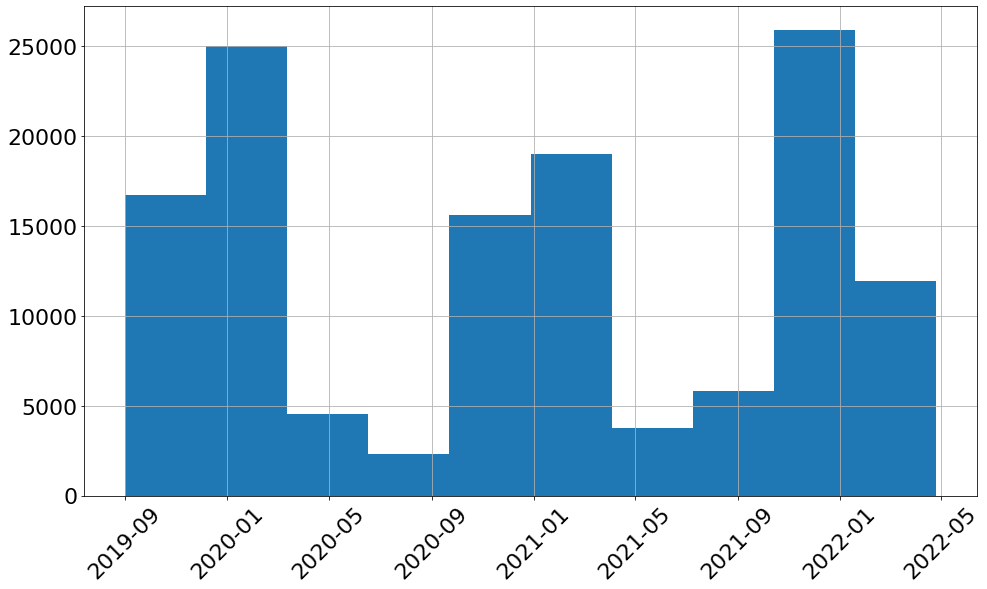

updated_at


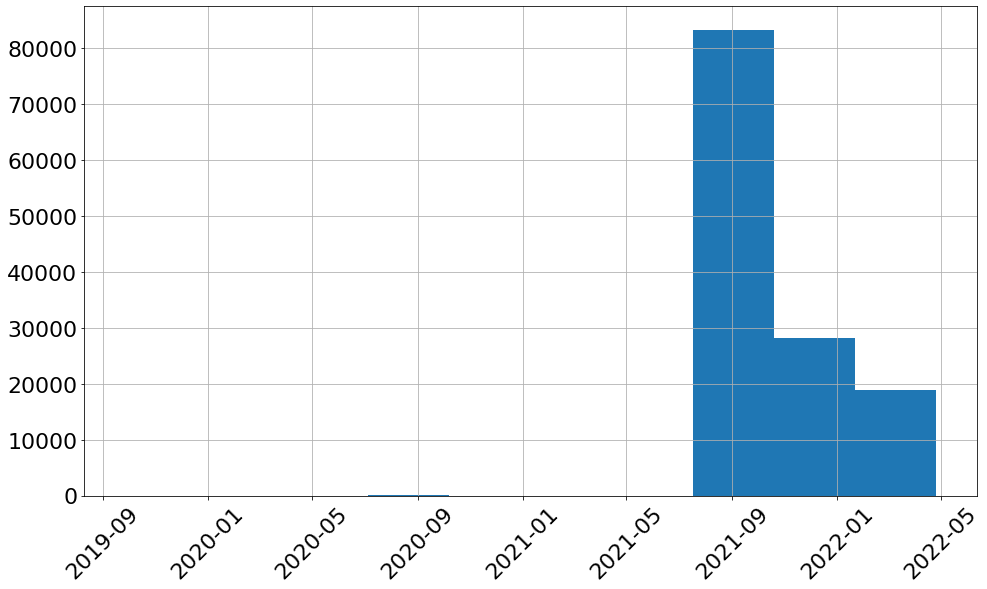

ts_registration


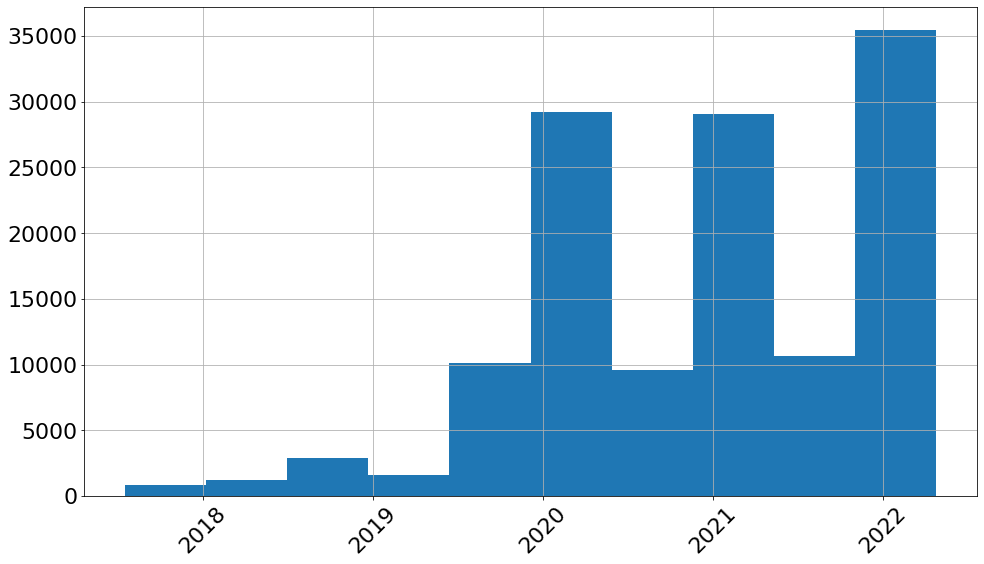

ts_login_first


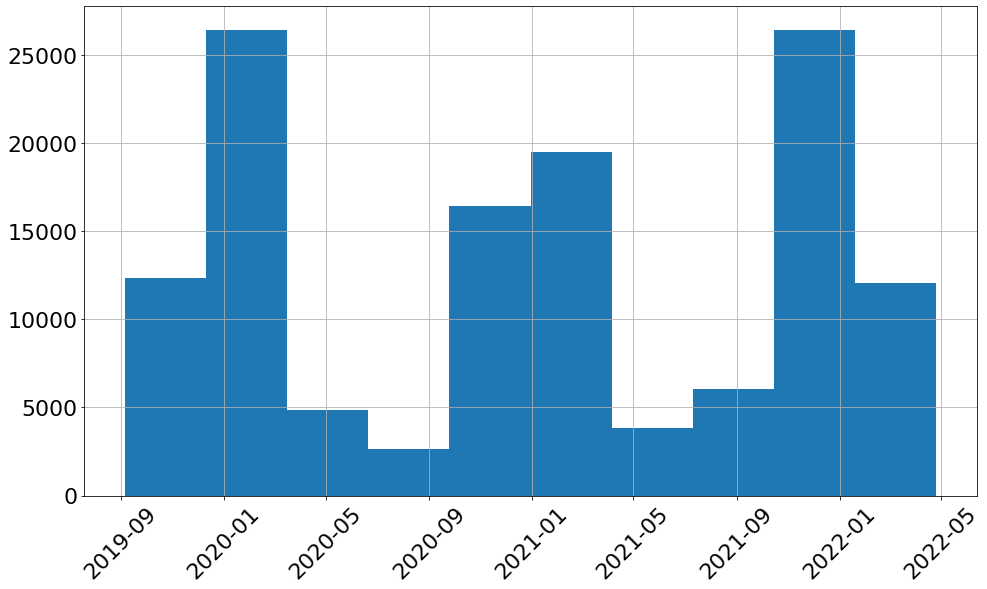

ts_login_last


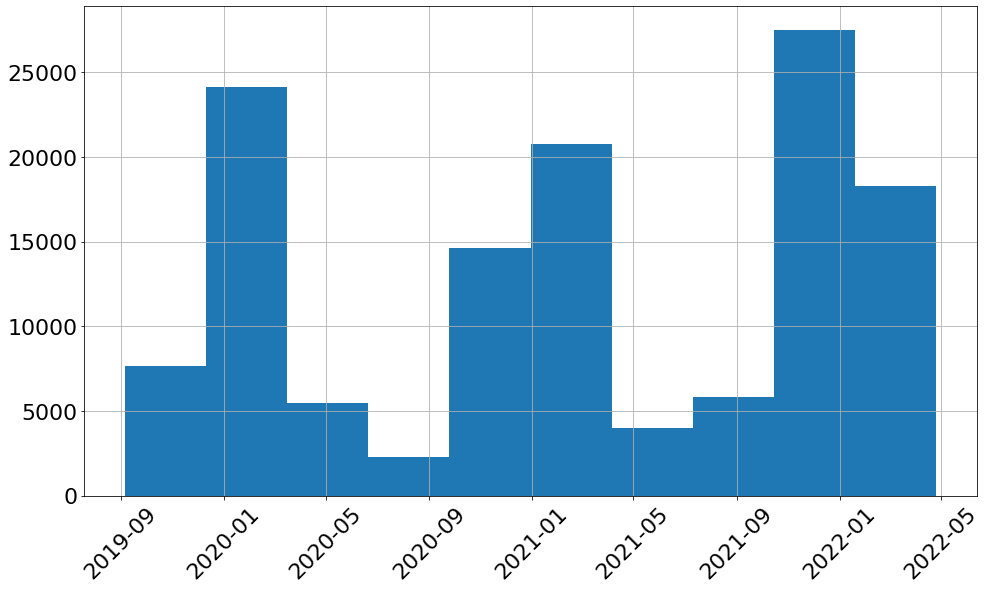

ts_visit_last


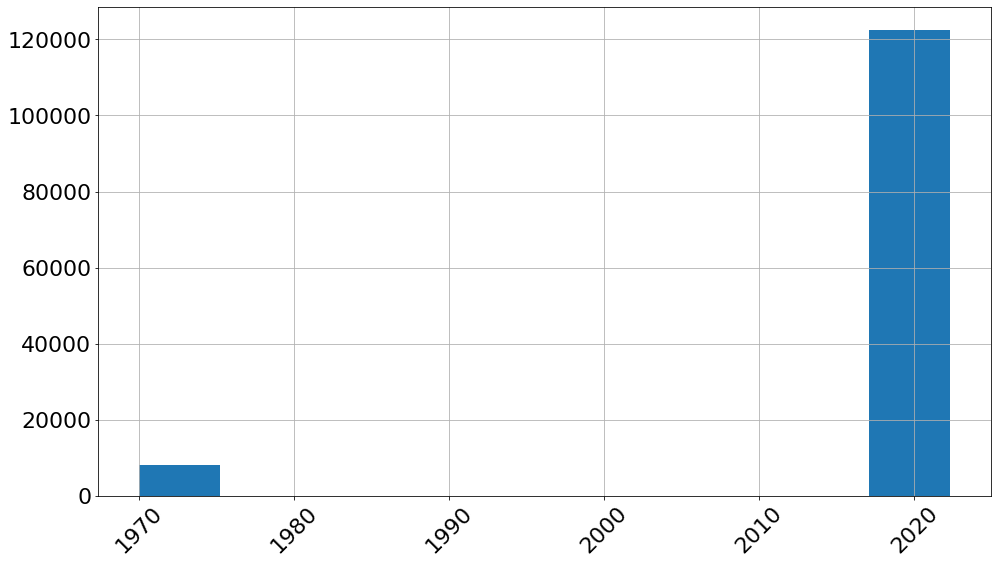

In [22]:
time_units = {'created_at':'s', 'updated_at':'s', 'ts_registration':'s',
             'ts_login_first':'s', 'ts_login_last':'s', 'ts_visit_last':'s'}

for unix_date_column in time_units.keys():
    print(unix_date_column)
    users[unix_date_column] = pd.to_datetime(users[unix_date_column], unit=time_units[unix_date_column])
    users[unix_date_column].hist()
    plt.xticks(rotation=45)
    plt.show()

Видим, что в `ts_visits_last` у нас 0 нужно было обрабатывать как nan'ы, но мы не скорее всего не будем использовать эту колонку вообще.

### <a id='toc7_1_2_'></a>[auth](#toc0_)

ti


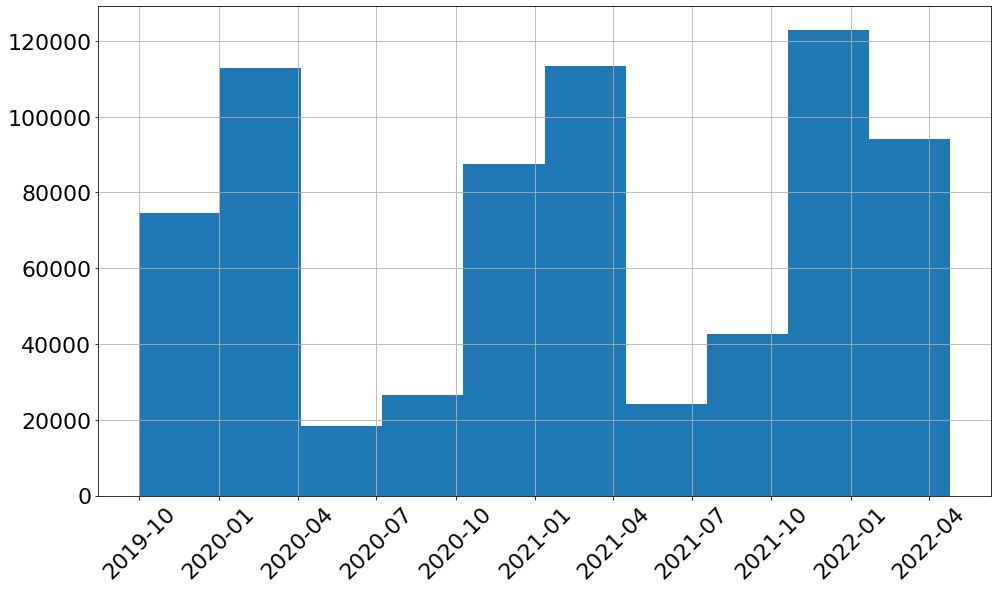

In [23]:
time_units = {'ti':'s'}

for unix_date_column in time_units.keys():
    print(unix_date_column)
    auth[unix_date_column] = pd.to_datetime(auth[unix_date_column], unit=time_units[unix_date_column])
    auth[unix_date_column].hist()
    plt.xticks(rotation=45)

### <a id='toc7_1_3_'></a>[gen_test](#toc0_)

generate_date


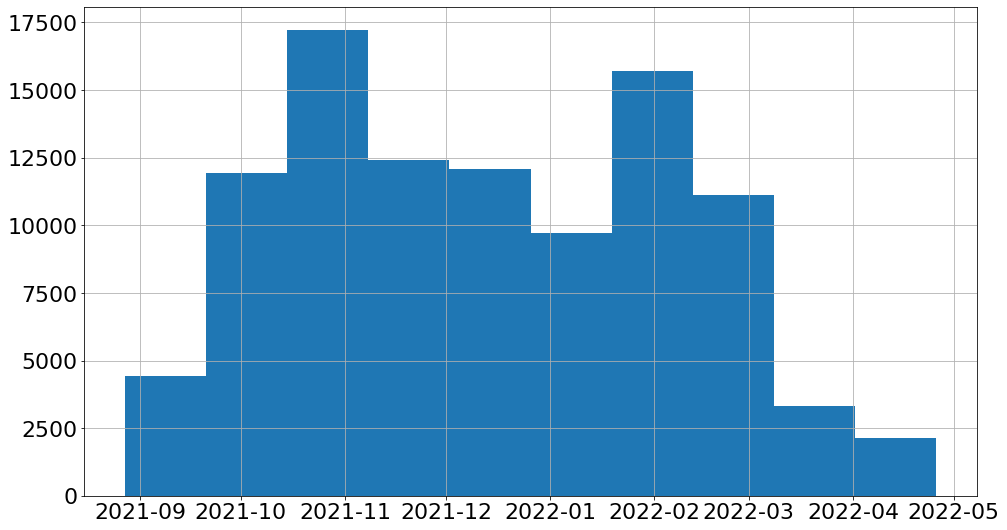

start


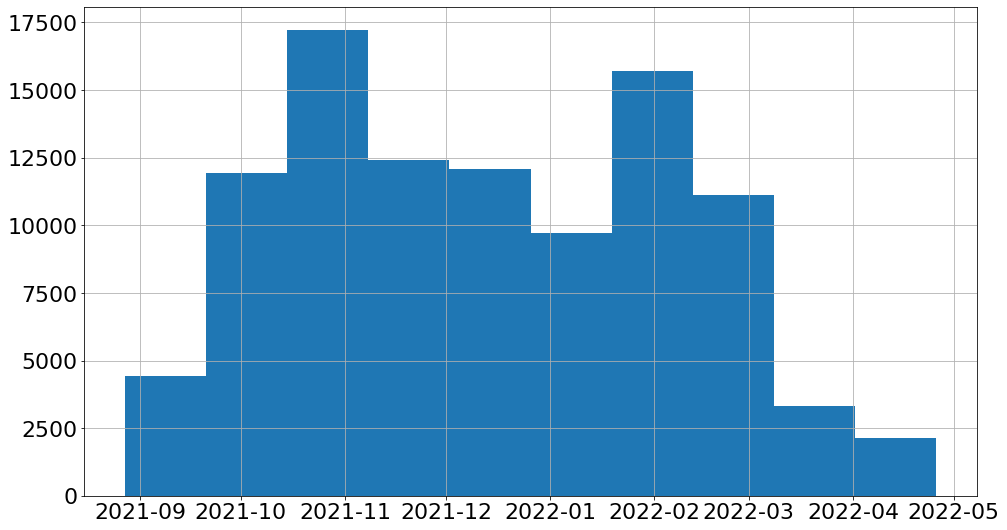

In [24]:
time_units = {'generate_date':'s', 'start':'ms'}
date_columns = ['generate_date', 'start']

for unix_date_column in date_columns:
    print(unix_date_column)
    gen_test[unix_date_column] = pd.to_datetime(gen_test[unix_date_column], unit=time_units[unix_date_column])
    gen_test[unix_date_column].hist()
    plt.show()

### <a id='toc7_1_4_'></a>[app](#toc0_)

ti


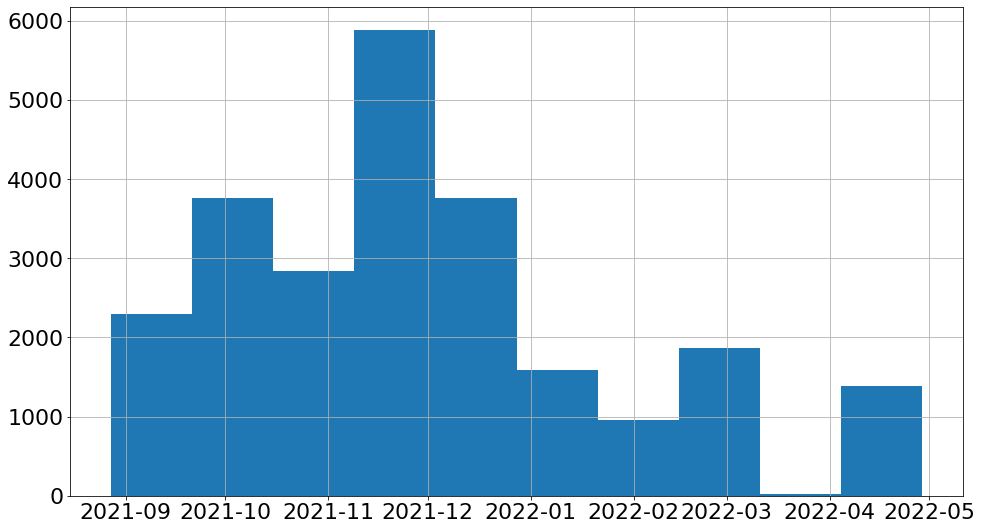

tu


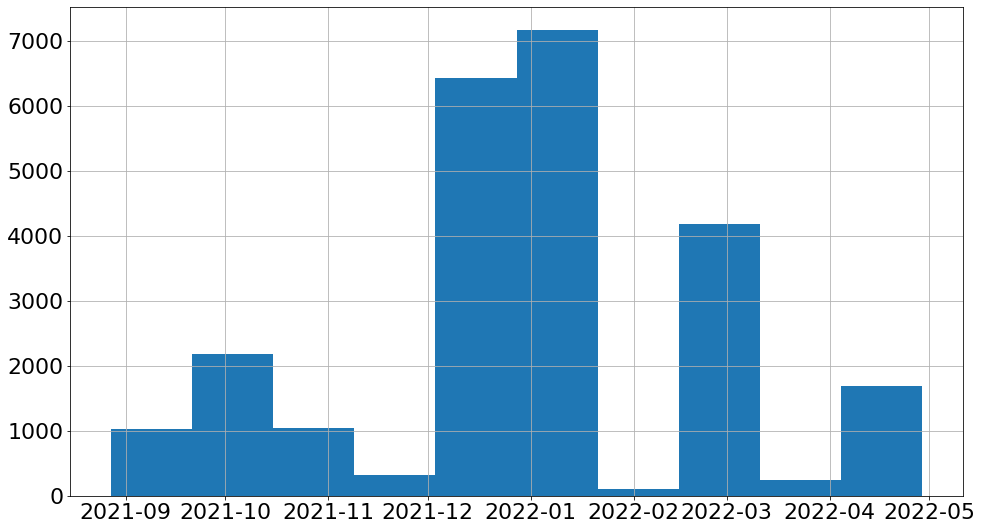

reviewed_at


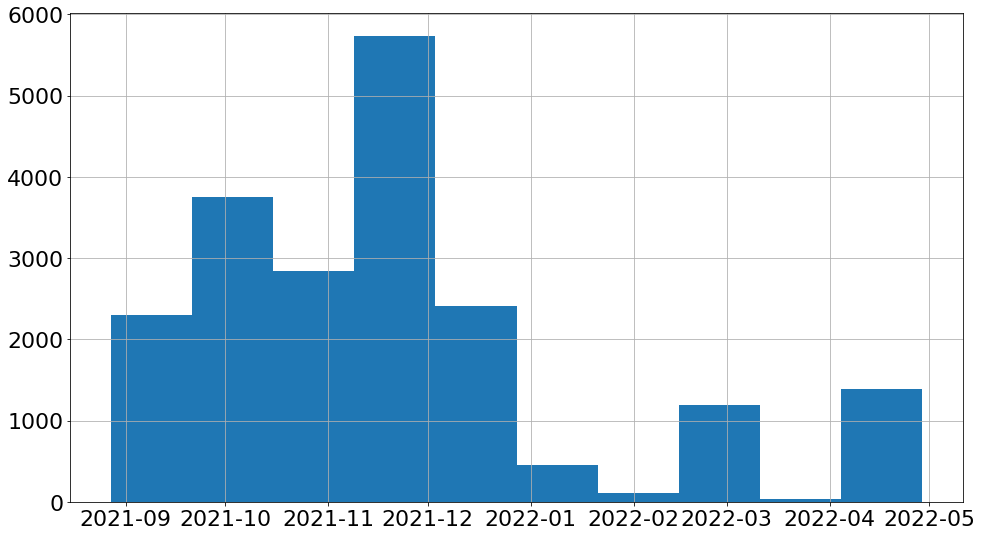

In [25]:
time_units = {'ti':'s', 'tu':'s', 'reviewed_at':'s'}
date_columns = ['ti', 'tu', 'reviewed_at']

for unix_date_column in date_columns:
    print(unix_date_column)
    app[unix_date_column] = pd.to_datetime(
        app[unix_date_column], 
        unit=time_units[unix_date_column])
    app[unix_date_column].hist()
    plt.show()

### <a id='toc7_1_5_'></a>[olymp](#toc0_)

In [26]:
olymp.columns

Index(['ID результата', 'Предмет', 'Класс', 'ID задания', 'Задание',
       'GID абитуриента', 'Правильное решение', 'Ответ ученика', 'Статус',
       'Дата выполнения', 'Баллы задания', 'Использованные подсказки',
       'Просмотр решения', 'Результат'],
      dtype='object')

<AxesSubplot:>

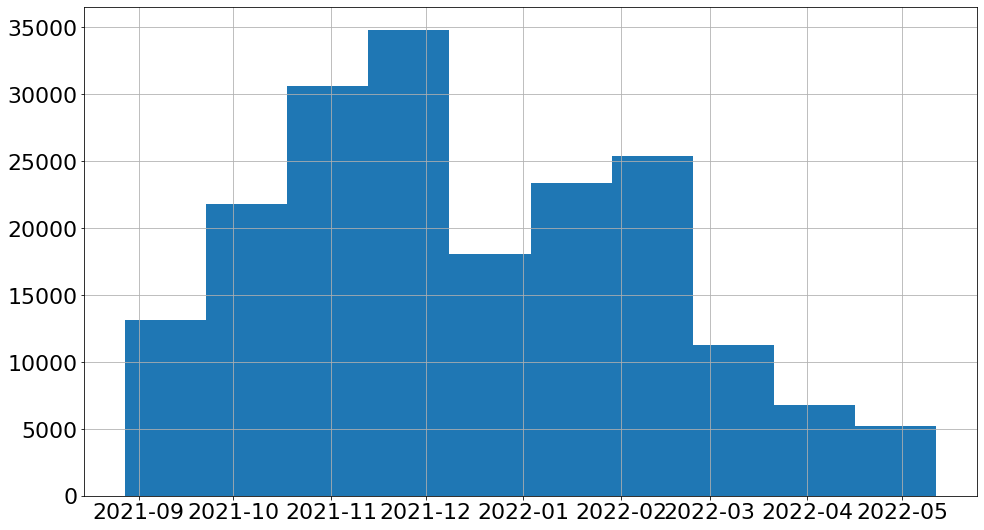

In [27]:
olymp['Дата выполнения'] = pd.to_datetime(olymp['Дата выполнения'], dayfirst=True)
olymp['Дата выполнения'].hist()

## <a id='toc7_2_'></a>[Месяц и день](#toc0_)

In [28]:
# Определяем день, неделя и месяц первой активности
users['first_login_D'] = users['ts_login_first'].astype('datetime64[D]')
users['first_login_M'] = users['ts_login_first'].astype('datetime64[M]')
users['first_login_W'] = users['first_login_D'] - pd.to_timedelta(users['first_login_D'].dt.dayofweek, unit='d')
users

,id,created_at,updated_at,id___global,grade_id,f_demo,f_active,f_registered,id__reg_place,ts_registration,ts_login_first,ts_login_last,ts_visit_last,visit_number,first_login_D,first_login_M,first_login_W
36,9803,2019-08-31 19:42:48,2021-10-16 15:58:33,1995,7,0,1,1,1,2017-09-20 08:35:33,2019-12-22 04:49:05,2021-10-16 15:35:01,2021-10-16 15:58:33,7,2019-12-22,2019-12-01,2019-12-16
38,9805,2019-08-31 19:42:48,2021-08-30 18:51:23,37677,7,0,1,1,1,2018-10-03 12:41:36,2019-09-06 06:20:53,2021-03-29 18:00:32,2021-03-29 18:07:41,2,2019-09-06,2019-09-01,2019-09-02
43,9811,2019-08-31 19:42:48,2022-02-27 19:11:04,985,11,0,1,1,1,2017-09-20 08:36:10,2022-02-27 03:23:34,2022-02-27 03:23:34,2022-02-27 19:11:04,1,2022-02-27,2022-02-01,2022-02-21
51,9819,2019-08-31 19:42:48,2021-08-30 13:37:52,1479,11,0,1,1,1,2017-09-20 08:35:52,2020-07-13 11:48:16,2020-11-04 12:08:43,2020-11-04 12:09:03,1,2020-07-13,2020-07-01,2020-07-13
67,9835,2019-08-31 19:42:49,2021-08-31 00:16:29,73964,10,0,1,1,1,2019-02-27 16:28:09,2020-01-25 17:38:33,2020-02-23 20:32:33,2020-02-23 20:39:13,0,2020-01-25,2020-01-01,2020-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217283,227138,2022-04-25 18:58:08,2022-04-25 20:24:41,230219,7,0,1,1,2,2022-04-25 18:58:08,2022-04-25 18:58:09,2022-04-25 18:58:09,2022-04-25 20:24:41,1,2022-04-25,2022-04-01,2022-04-25
217284,227139,2022-04-25 19:03:12,2022-04-25 19:04:36,230220,5,0,1,1,2,2022-04-25 19:03:12,2022-04-25 19:03:12,2022-04-25 19:03:12,2022-04-25 19:04:36,1,2022-04-25,2022-04-01,2022-04-25
217285,227140,2022-04-25 19:40:24,2022-04-25 19:41:38,230221,8,0,1,1,2,2022-04-25 19:40:23,2022-04-25 19:40:24,2022-04-25 19:40:24,2022-04-25 19:41:38,1,2022-04-25,2022-04-01,2022-04-25
217287,227142,2022-04-25 22:22:56,2022-04-25 22:23:06,230223,8,0,1,1,2,2022-04-25 22:22:55,2022-04-25 22:22:56,2022-04-25 22:22:56,2022-04-25 22:23:06,1,2022-04-25,2022-04-01,2022-04-25


In [29]:
# День и месяц для всех активностей
auth['M'] = auth['ti'].astype('datetime64[M]')
auth['D'] = auth['ti'].astype('datetime64[D]')
auth['W'] = auth['D'] - pd.to_timedelta(auth['D'].dt.dayofweek, unit='d')
auth

,id,idc_type,id_user__login,id_user__supervisor,ti,nd,M,D,W
0,1,2,32905,0,2019-09-30 11:05:41,NaN,2019-09-01,2019-09-30,2019-09-30
1,2,2,26297,0,2019-09-30 11:13:10,NaN,2019-09-01,2019-09-30,2019-09-30
2,3,2,24209,0,2019-09-30 11:18:26,NaN,2019-09-01,2019-09-30,2019-09-30
6,7,1,67864,0,2019-09-30 11:36:11,NaN,2019-09-01,2019-09-30,2019-09-30
7,8,2,41275,0,2019-09-30 11:38:29,NaN,2019-09-01,2019-09-30,2019-09-30
...,...,...,...,...,...,...,...,...,...
791162,791163,2,183841,0,2022-04-25 20:51:37,NaN,2022-04-01,2022-04-25,2022-04-25
791163,791164,1,132320,0,2022-04-25 21:13:29,NaN,2022-04-01,2022-04-25,2022-04-25
791164,791165,2,184471,0,2022-04-25 21:18:25,NaN,2022-04-01,2022-04-25,2022-04-25
791166,791167,1,214823,0,2022-04-25 22:29:35,NaN,2022-04-01,2022-04-25,2022-04-25


## <a id='toc7_3_'></a>[App](#toc0_)

In [30]:
app['user_id'] = app['user_id'].astype('int')
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24368 entries, 0 to 24367
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        24368 non-null  object        
 1   club_id                   24368 non-null  object        
 2   user_id                   24368 non-null  int64         
 3   state                     24368 non-null  object        
 4   ti                        24368 non-null  datetime64[ns]
 5   tu                        24368 non-null  datetime64[ns]
 6   reviewed_at               20205 non-null  datetime64[ns]
 7   reviewer_id               0 non-null      object        
 8   note_teacher_about_user   301 non-null    object        
 9   f_lesson_disabled_by_ts   24368 non-null  object        
 10  ts_lesson_disabled_start  7738 non-null   object        
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 2.0+ MB


In [31]:
bad_club_id = [18, 51, 54, 55]
app['club_id'] = app['club_id'].astype('int')
#Заявки на курсы - это good
app_good = app.query('club_id not in @bad_club_id').copy()
#Заявки на олимпиады - это bad
app_bad = app.query('club_id in @bad_club_id').copy()

## <a id='toc7_4_'></a>[School_app](#toc0_)

In [32]:
school_app['crm_lead_id'] = school_app['crm_lead_id'].astype('int')
school_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6855 entries, 0 to 6854
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   crm_lead_id  6855 non-null   int64 
 1   status       6854 non-null   object
 2   is_app_sent  6855 non-null   object
dtypes: int64(1), object(2)
memory usage: 160.8+ KB


## <a id='toc7_5_'></a>[Вывод по предобработке](#toc0_)

- Где можно заменили даты с юниксовских на обычный datetime.
- Добавили колонки с месяцем и днем для таблиц _users_ и _auth_.
- Поменяли типы данных для `id`
- В таблице с заявками выделили курсы и олимпиады

# <a id='toc8_'></a>[EDA](#toc0_)

## <a id='toc8_1_'></a>[Пересечение таблиц users и auth по пользователям](#toc0_)

In [33]:
len(users.id.unique())

130634

In [34]:
len(auth.id_user__login.unique())

65697

In [35]:
id_auth_only = list(set(auth['id_user__login']) - set(users['id']))
len(id_auth_only)

34

In [36]:
id_users_only = list(set(users['id']) - set(auth['id_user__login']))
len(id_users_only)

64971

Имеем 34 пользователя в таблице _auth_, которых нет в _users_, и 64971 пользователь, которые есть в _users_, но нет в _auth_.

In [37]:
auth.query('id_user__login in @id_auth_only')

,id,idc_type,id_user__login,id_user__supervisor,ti,nd,M,D,W
262,263,2,80035,0,2019-10-01 07:58:02,NaN,2019-10-01,2019-10-01,2019-09-30
9930,9931,2,84392,0,2019-10-24 11:20:46,NaN,2019-10-01,2019-10-24,2019-10-21
15695,15696,2,86578,0,2019-10-30 09:39:17,NaN,2019-10-01,2019-10-30,2019-10-28
18183,18184,2,82024,0,2019-11-01 11:33:18,NaN,2019-11-01,2019-11-01,2019-10-28
22907,22908,1,86578,0,2019-11-05 19:24:55,NaN,2019-11-01,2019-11-05,2019-11-04
...,...,...,...,...,...,...,...,...,...
693746,693747,1,213494,0,2022-01-26 09:32:34,NaN,2022-01-01,2022-01-26,2022-01-24
693749,693750,2,213494,0,2022-01-26 09:34:41,NaN,2022-01-01,2022-01-26,2022-01-24
723315,723316,2,218782,0,2022-02-11 10:13:02,NaN,2022-02-01,2022-02-11,2022-02-07
785082,785083,2,84392,0,2022-04-11 17:45:52,NaN,2022-04-01,2022-04-11,2022-04-11


In [38]:
users.query('id in @id_users_only')

,id,created_at,updated_at,id___global,grade_id,f_demo,f_active,f_registered,id__reg_place,ts_registration,ts_login_first,ts_login_last,ts_visit_last,visit_number,first_login_D,first_login_M,first_login_W
402,10170,2019-08-31 20:08:57,2021-11-30 12:58:42,28055,9,0,1,1,1,2018-03-02 13:25:26,2019-09-09 11:58:15,2019-09-09 11:58:15,1970-01-01 00:00:00,0,2019-09-09,2019-09-01,2019-09-09
544,10313,2019-08-31 20:08:59,2021-08-31 00:21:40,74793,11,0,1,1,1,2019-03-05 04:23:44,2019-09-27 13:26:54,2019-09-27 13:26:54,1970-01-01 00:00:00,0,2019-09-27,2019-09-01,2019-09-23
1136,10906,2019-08-31 20:11:29,2021-08-31 00:30:46,76184,9,0,1,1,1,2019-03-13 09:41:34,2019-09-23 17:47:34,2019-09-23 17:47:34,1970-01-01 00:00:00,0,2019-09-23,2019-09-01,2019-09-23
1391,11161,2019-08-31 20:11:33,2021-08-31 00:10:38,73133,9,0,1,1,1,2019-02-22 18:02:29,2020-05-07 10:39:43,2020-05-07 10:54:54,2020-05-07 10:54:54,0,2020-05-07,2020-05-01,2020-05-04
1992,11762,2019-08-31 20:13:21,2021-08-30 14:53:00,15371,11,0,1,1,1,2018-01-02 15:33:44,2019-09-07 10:40:08,2019-09-07 10:40:08,1970-01-01 00:00:00,0,2019-09-07,2019-09-01,2019-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217283,227138,2022-04-25 18:58:08,2022-04-25 20:24:41,230219,7,0,1,1,2,2022-04-25 18:58:08,2022-04-25 18:58:09,2022-04-25 18:58:09,2022-04-25 20:24:41,1,2022-04-25,2022-04-01,2022-04-25
217284,227139,2022-04-25 19:03:12,2022-04-25 19:04:36,230220,5,0,1,1,2,2022-04-25 19:03:12,2022-04-25 19:03:12,2022-04-25 19:03:12,2022-04-25 19:04:36,1,2022-04-25,2022-04-01,2022-04-25
217285,227140,2022-04-25 19:40:24,2022-04-25 19:41:38,230221,8,0,1,1,2,2022-04-25 19:40:23,2022-04-25 19:40:24,2022-04-25 19:40:24,2022-04-25 19:41:38,1,2022-04-25,2022-04-01,2022-04-25
217287,227142,2022-04-25 22:22:56,2022-04-25 22:23:06,230223,8,0,1,1,2,2022-04-25 22:22:55,2022-04-25 22:22:56,2022-04-25 22:22:56,2022-04-25 22:23:06,1,2022-04-25,2022-04-01,2022-04-25


In [39]:
id_auth_only = list(set(auth['id_user__login']) - set(users['id']))
auth.query('id_user__login in @id_auth_only')

,id,idc_type,id_user__login,id_user__supervisor,ti,nd,M,D,W
262,263,2,80035,0,2019-10-01 07:58:02,NaN,2019-10-01,2019-10-01,2019-09-30
9930,9931,2,84392,0,2019-10-24 11:20:46,NaN,2019-10-01,2019-10-24,2019-10-21
15695,15696,2,86578,0,2019-10-30 09:39:17,NaN,2019-10-01,2019-10-30,2019-10-28
18183,18184,2,82024,0,2019-11-01 11:33:18,NaN,2019-11-01,2019-11-01,2019-10-28
22907,22908,1,86578,0,2019-11-05 19:24:55,NaN,2019-11-01,2019-11-05,2019-11-04
...,...,...,...,...,...,...,...,...,...
693746,693747,1,213494,0,2022-01-26 09:32:34,NaN,2022-01-01,2022-01-26,2022-01-24
693749,693750,2,213494,0,2022-01-26 09:34:41,NaN,2022-01-01,2022-01-26,2022-01-24
723315,723316,2,218782,0,2022-02-11 10:13:02,NaN,2022-02-01,2022-02-11,2022-02-07
785082,785083,2,84392,0,2022-04-11 17:45:52,NaN,2022-04-01,2022-04-11,2022-04-11


## <a id='toc8_2_'></a>[Время регистрации в системе](#toc0_)

In [40]:
users['ts_created_minus_reg'] = users['created_at'] - users['ts_registration']
users['ts_created_minus_reg'].describe()

count                        130634
mean     18 days 17:54:03.905376854
std      89 days 18:48:16.454090937
min             -422 days +10:05:26
25%                 0 days 00:00:01
50%                 0 days 00:00:01
75%                 0 days 00:00:02
max              1357 days 10:05:08
Name: ts_created_minus_reg, dtype: object

<AxesSubplot:ylabel='Frequency'>

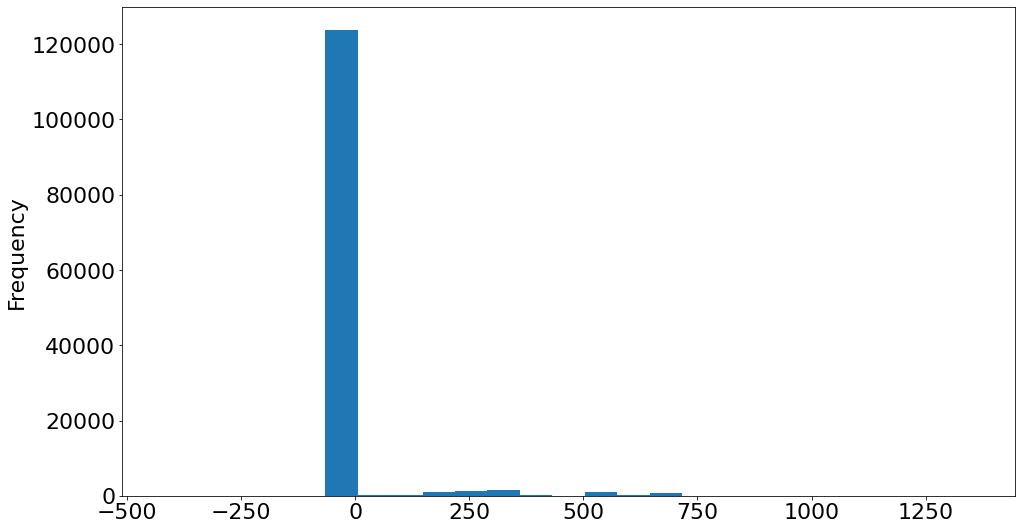

In [41]:
users['ts_created_minus_reg'].astype('timedelta64[D]').plot(kind='hist', bins=25)

Мы видим, что в основном разницы между двумя столбцами нет, но иногда `ts_registration` оказывается раньше, чем `created_at`. Это видно и при сравнении гистограмм:

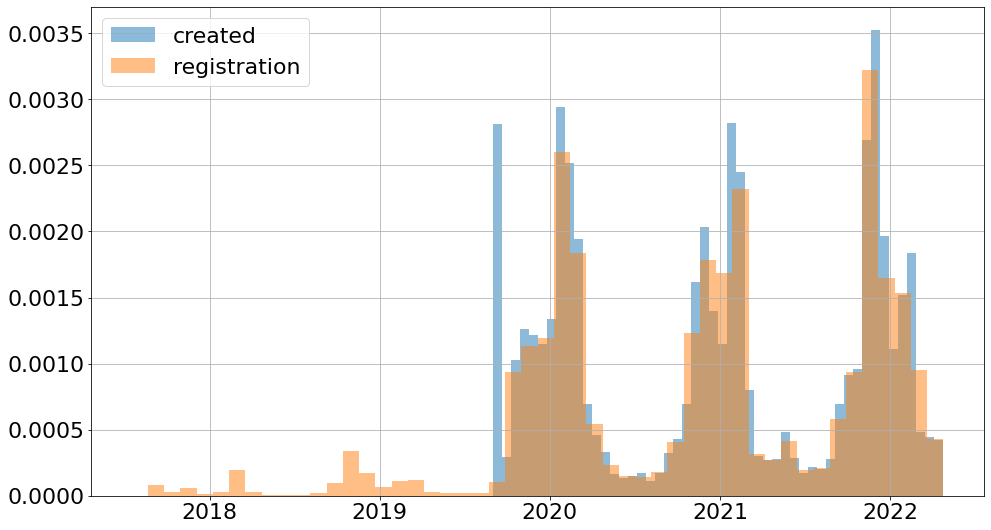

In [42]:
users['created_at'].hist(alpha=0.5, label='created', bins=50, density=True)
users['ts_registration'].hist(alpha=0.5, label='registration', bins=50, density=True)
plt.legend()

Видим интересный спайк для `created_at` в районе сентября 2019. Скорее всего просто всем регистрациям, отраженным в `ts_registration` до этого времени, было искусственно переписана дата сентябрь 2019 в столбец `сreated_at`.

In [43]:
users = users.drop(['ts_created_minus_reg'], axis=1)

## <a id='toc8_3_'></a>[Логины](#toc0_)

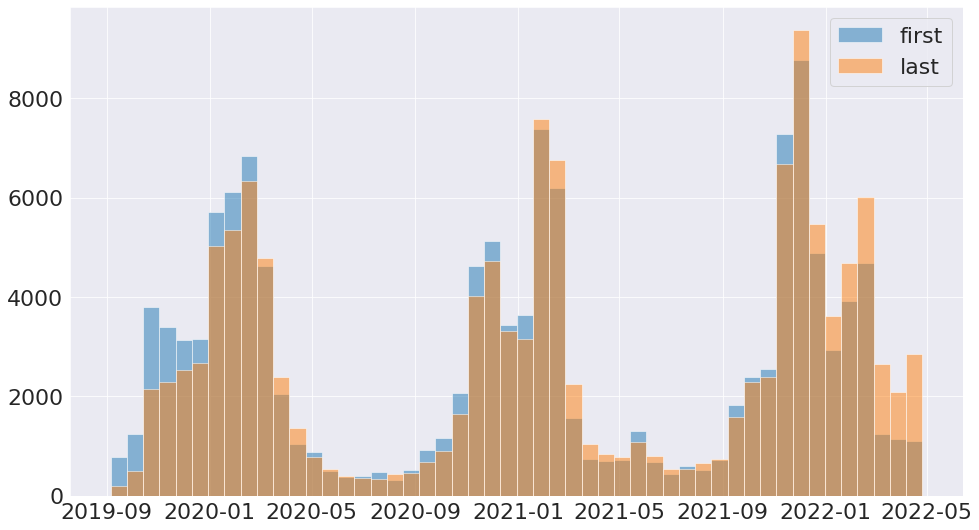

In [44]:
with sns.axes_style('darkgrid'):    
    users['ts_login_first'].hist(alpha=.5, label='first', bins=50)
    users['ts_login_last'].hist(alpha=.5, label='last', bins=50)
    plt.legend()

In [45]:
users['ts_login_first'].describe()

count                  130634
unique                 130303
top       2021-04-26 03:05:48
freq                        3
first     2019-09-05 15:28:20
last      2022-04-25 23:46:39
Name: ts_login_first, dtype: object

Тут все окей

## <a id='toc8_4_'></a>[Вывод по EDA](#toc0_)

- В таблице _auth_ есть 34 пользователя, которых нет в _users_. Наоборот в _users_ есть 64971 пользователь, которого нет в _auth_. Мы будем считать, что основной для нас является таблица _users_ и доверять ее данным.

- Время регистрации в системе задано не однозначно, есть разница между данными столбцов `created_at` и `ts_registration`. Вообще видно, что в момент создания `created_at` пользователям с `ts_registration` ранее сентября 2019 просто записали дату `created_at` как сентябрт 2019, из-за чего возник локальный пик на гистограме. В целом решили ориентироваться на логин, как первое действие.


# <a id='toc9_'></a>[Retention в логин](#toc0_)

## <a id='toc9_1_'></a>[Новые пользователи (от первого логина)](#toc0_)

### <a id='toc9_1_1_'></a>[Подготовка фичей для расчета retention](#toc0_)

In [46]:
users_columns = ['id', 'grade_id', 'id___global',
                 'first_login_M', 'first_login_W', 'first_login_D']
auth_columns = ['id','id_user__login', 'M', 'W', 'D']

# Сгенерирум таблицу фичей для расчета когорт
users_auth = users[users_columns].merge(
    auth[auth_columns], 
    left_on='id', 
    right_on='id_user__login', 
    how='left',
    suffixes=['_user', '_auth']
).drop('id_user__login', axis=1)

# Заполним пропуски для тех пользователей, для которых есть информация о первом
# логине в таблице users, но нет информации в таблице auth
users_auth['M'] = users_auth['M'].fillna(users_auth['first_login_M'])
users_auth['D'] = users_auth['D'].fillna(users_auth['first_login_D'])
users_auth['W'] = users_auth['W'].fillna(users_auth['first_login_W'])

#Избавимся от нескольких случаев, когда дата первого логина не минимальная дата авторизации
users_auth = users_auth[users_auth['M'] >= users_auth['first_login_M']]
users_auth = users_auth[users_auth['D'] >= users_auth['first_login_D']]
users_auth = users_auth[users_auth['W'] >= users_auth['first_login_W']]
users_auth

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D
0,9803,7,1995,2019-12-01,2019-12-16,2019-12-22,68988.0,2019-12-01,2019-12-16,2019-12-22
1,9803,7,1995,2019-12-01,2019-12-16,2019-12-22,68989.0,2019-12-01,2019-12-16,2019-12-22
2,9803,7,1995,2019-12-01,2019-12-16,2019-12-22,68991.0,2019-12-01,2019-12-16,2019-12-22
3,9803,7,1995,2019-12-01,2019-12-16,2019-12-22,69911.0,2019-12-01,2019-12-23,2019-12-23
4,9803,7,1995,2019-12-01,2019-12-16,2019-12-22,92856.0,2020-01-01,2020-01-20,2020-01-21
...,...,...,...,...,...,...,...,...,...,...
780803,227138,7,230219,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780804,227139,5,230220,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780805,227140,8,230221,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780806,227142,8,230223,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25


### <a id='toc9_1_2_'></a>[Правильный `grade_id` в зависимости от года](#toc0_)

В таблице _users_auth_ задан текущий grade_id на апрель 2022 года, т.е. для уч. года с началом в 2021 году. Трансформируем `grade_id` так, чтобы он отражал __актуальный grade_id на дату действия__:

In [47]:
users_auth.loc[users_auth['D'] < '2021-09-01','grade_id'] -= 1
users_auth.loc[users_auth['D'] < '2020-09-01','grade_id'] -= 1
users_auth

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D
0,9803,5,1995,2019-12-01,2019-12-16,2019-12-22,68988.0,2019-12-01,2019-12-16,2019-12-22
1,9803,5,1995,2019-12-01,2019-12-16,2019-12-22,68989.0,2019-12-01,2019-12-16,2019-12-22
2,9803,5,1995,2019-12-01,2019-12-16,2019-12-22,68991.0,2019-12-01,2019-12-16,2019-12-22
3,9803,5,1995,2019-12-01,2019-12-16,2019-12-22,69911.0,2019-12-01,2019-12-23,2019-12-23
4,9803,5,1995,2019-12-01,2019-12-16,2019-12-22,92856.0,2020-01-01,2020-01-20,2020-01-21
...,...,...,...,...,...,...,...,...,...,...
780803,227138,7,230219,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780804,227139,5,230220,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780805,227140,8,230221,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25
780806,227142,8,230223,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25


Оставим только 5-8 классы в таблицах auth и users

In [48]:
users_auth = users_auth.query('6 <= grade_id <= 8')
users_grades_6_8 = users_auth['id_user'].unique()
users = users.query('id in @users_grades_6_8')

### <a id='toc9_1_3_'></a>[Функция подсчета retention и график heatmap](#toc0_)

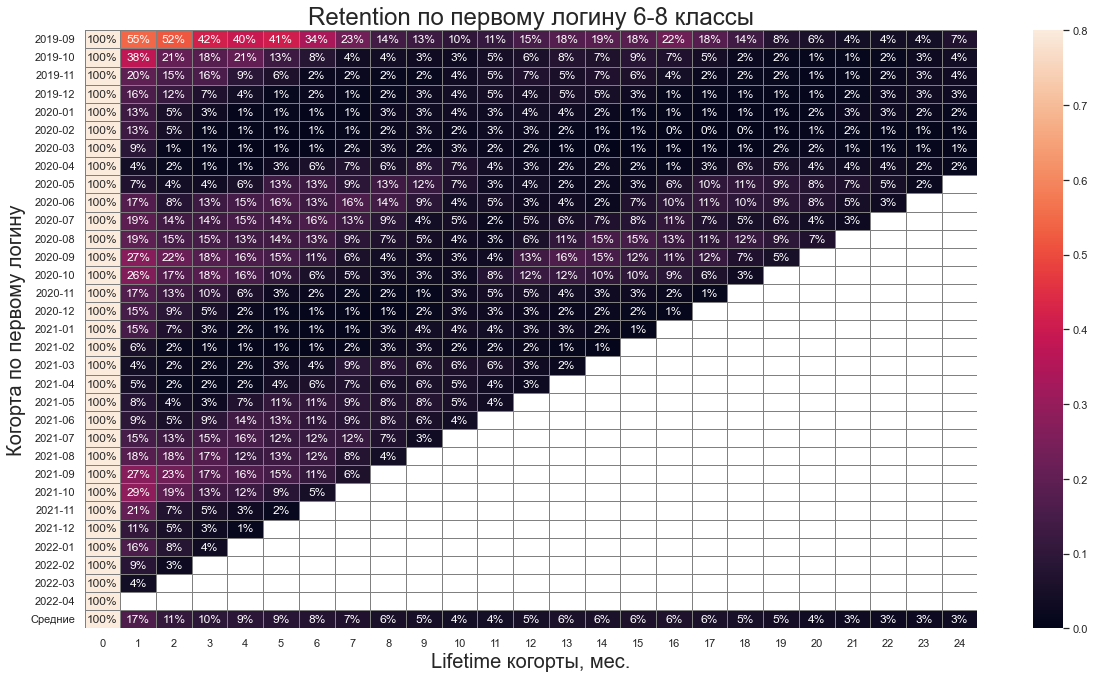

In [49]:
def retention_first_auth(df=users_auth, 
                         period:str='M', 
                         max_lifetime:int=24,
                         heat_title:str = 'Retention по первому логину 6-8 классы',
                         file_name:str='retention_first_login_grades_6_8',
                         figsize:tuple=(16,9),
                         yticks_rotation:int=0) -> pd.DataFrame: 
    
    if period not in ['M', 'W', 'D']:
        raise ValueError
        print('Illegal period value. Try: "M", "W" or "D".')
    
    # Выделим когорту для каждого логина
    df['cohort_lifetime'] = df[period] - df['first_login_' + period]
    df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1, period)
    # round нужен для того, чтобы избежать ошибок, когда получаем чуть меньше целого числа
    df['cohort_lifetime'] = df['cohort_lifetime'].round(0).astype('int')
    
    #display(df.query('first_login_M == "2019-09-01"'))
    
    # У нас бывает так, что cohort_lifetime начинается не с нуля для некоторых user_id,
    # поэтому необходимо добавить нулевые cohort_lifetime
    ids_cohort_min = df.groupby(['id_user', 'first_login_' + period])['cohort_lifetime'].min()
    ids_no_cohort_0 = ids_cohort_min[ids_cohort_min != 0].index
    zero_cohort_add = pd.Series(data=0, index = ids_no_cohort_0, name='cohort_lifetime').reset_index()
    
    result = pd.concat([df, zero_cohort_add], axis=0, ignore_index=True, copy=False)
    
    result = result.query('cohort_lifetime <= @max_lifetime')
    

    # Сгруппируем по когортам и их lifetime и выведем число оставшихся уникальных 
    # пользователей на каждый период жизни когорты.
    cohorts = result.groupby(
        ['first_login_'+period,'cohort_lifetime']
    ).agg({'id_user':'nunique'}).reset_index()
    
    #Посчитаем исходное число пользователей в каждой когорте
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_login_' + period,'id_user']]
    initial_users_count = initial_users_count.rename(columns={'id_user':'cohort_users'}) 
    cohorts = cohorts.merge(initial_users_count, on='first_login_' + period)

    cohorts = cohorts[cohorts['cohort_users'] >= 30]
    #display(cohorts)
    # Вычислим retention
    cohorts['retention'] = cohorts['id_user'] / cohorts['cohort_users']
    

    
    retention_pivot = cohorts.pivot_table(
        index='first_login_' + period,
        columns='cohort_lifetime',
        values='retention') 
    
    y_ticks = pd.Series(retention_pivot.index).dt.strftime('%Y-%m').tolist() + ['Средние']
    
    sns.set(style='white', font_scale=1)
    fig = plt.figure(figsize=figsize)
    
    
    rr_mean = retention_pivot.mean()
    rr_mean.name = 'Средние'
    retention_pivot = retention_pivot.append(rr_mean)
    
    ax = sns.heatmap(
        retention_pivot, 
        annot=True, 
        fmt='.0%', 
        linewidths=1, 
        linecolor='gray', 
        vmin=0, vmax=0.8,
        yticklabels=y_ticks
    )
    
    label_dict = {
        'M':'мес.',
        'W':'нед.',
        'D':'день'
    }
    
    plt.title(heat_title, size=24)  
    plt.xlabel('Lifetime когорты, ' + label_dict[period], size=20) 
    plt.ylabel('Когорта по первому логину', size=20)
    plt.yticks(rotation=yticks_rotation)
    
    plt.show()
    
    fig.savefig(file_name +'.png')
    retention_pivot.to_csv(file_name + '.csv')
    
    return retention_pivot

retention_pivot_all = retention_first_auth(figsize=(20,11))   

### <a id='toc9_1_4_'></a>[По месяцам года](#toc0_)

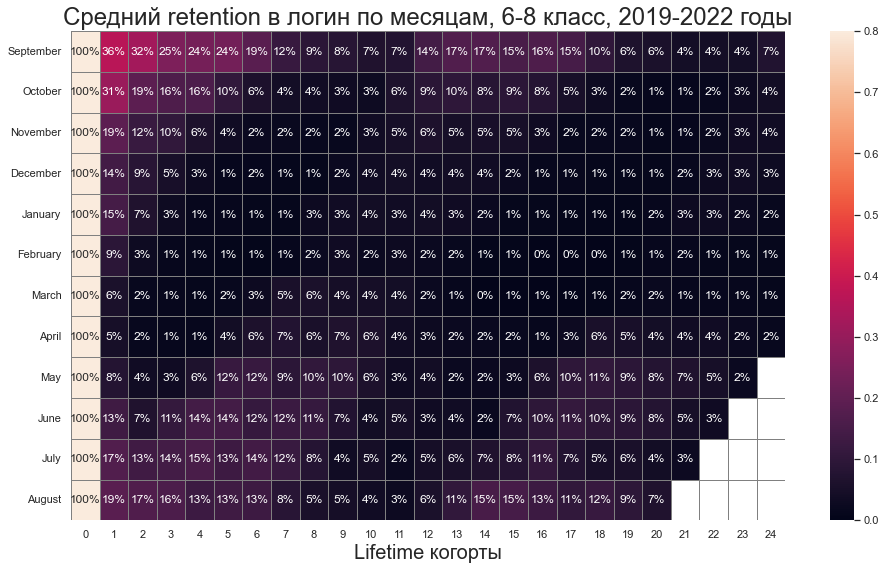

In [50]:
def retention_monthly(retention_pivot = retention_pivot_all,
                      title='Средний retention в логин по месяцам, 6-8 класс, 2019-2022 годы',
                     figsize=(16,9),
                     file_name='retention_first_login_monthly_grades_6_8'):
    retention_pivot = retention_pivot.drop('Средние').reset_index()
    retention_pivot['month'] = pd.to_datetime(retention_pivot['first_login_M']).dt.month_name()
    
    retention_monthly_mean = retention_pivot.groupby('month').mean().loc[
        ['September', 'October', 'November', 
         'December', 'January', 'February',
         'March', 'April', 'May', 
         'June', 'July', 'August'], :]

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
            retention_monthly_mean, 
            annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='gray', 
            vmin=0, vmax=0.8
        )

    plt.title(title, size=24)
    plt.xlabel('Lifetime когорты', size=20)
    plt.ylabel('', size=20)
    plt.show()
    
    fig.savefig(file_name + '.png')
    
    return retention_monthly_mean

retention_monthly();

Видим, что в среднем по месяцам за 2019-2022 годы у нас __активнее всего возвращаются после первого логина сентябрьские и октябрьские когорты__. Это вполне ожидаемо, ведь речь идет о начале учебного года.

Наверное тем же объясняется высокий возврат для августовской и июльской когорт.

### <a id='toc9_1_5_'></a>[2021-2022](#toc0_)

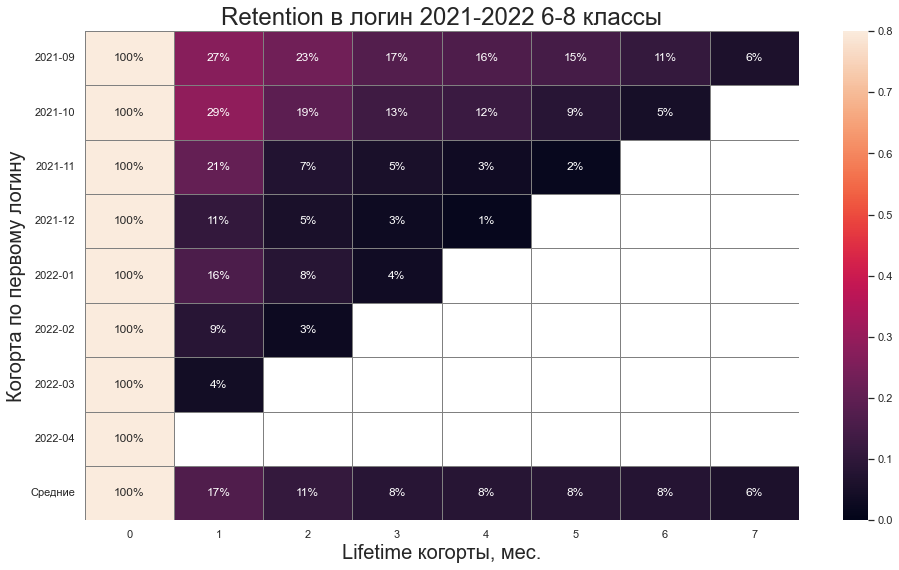

cohort_lifetime,0,1,2,3,4,5,6,7
first_login_M,,,,,,,,
2021-09-01 00:00:00,1.0,0.274175,0.230944,0.173493,0.163823,0.146758,0.111490,0.061433
2021-10-01 00:00:00,1.0,0.290244,0.191289,0.131359,0.123345,0.085366,0.048780,NaN
2021-11-01 00:00:00,1.0,0.207197,0.073957,0.054327,0.032914,0.016358,NaN,NaN
2021-12-01 00:00:00,1.0,0.107467,0.054112,0.029516,0.014506,NaN,NaN,NaN
2022-01-01 00:00:00,1.0,0.160730,0.083508,0.036217,NaN,NaN,NaN,NaN
2022-02-01 00:00:00,1.0,0.085024,0.025986,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,1.0,0.039484,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01 00:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Средние,1.0,0.166332,0.109966,0.084982,0.083647,0.082827,0.080135,0.061433


In [51]:
retention_first_auth(
    df=users_auth.query('first_login_M >= "2021-09-01"'),
    heat_title='Retention в логин 2021-2022 6-8 классы',
    file_name='retention_first_login_2021_2022_grades_6_8'
)

## <a id='toc9_2_'></a>[Пользователи, которые начали тест в течение 14 дней после первого логина](#toc0_)

Для начала получим первые даты начала тестов для всех пользователей:

In [52]:
first_test_start_dates = gen_test.groupby('user_id')['start'].min()
first_test_start_dates.name = 'test_start'

users = users.join(first_test_start_dates, on='id', how='left')

strange_test_start_len = len(users.query('test_start < ts_login_first'))
print(f'Кол-во пользователей, для которых начало первого теста раньше первого логина, = {strange_test_start_len}')

Кол-во пользователей, для которых начало первого теста раньше первого логина, = 0


Пользователи, которые начали тест в течение 14 дней, после логина:

In [53]:
users['first_test_start_after_first_login_D'] = (
    (users['test_start'] - users['ts_login_first']) / np.timedelta64(1, 'D')
)

users_14_days_test_start = users.query('first_test_start_after_first_login_D < 14')['id'].unique().tolist()
users_auth_14_days_test_start = users_auth.query('id_user in @users_14_days_test_start').copy()
users_auth_14_days_test_start

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
3467,10801,8,49199,2022-02-01,2022-01-31,2022-02-06,712872.0,2022-02-01,2022-01-31,2022-02-06,0
3478,10903,8,3171,2021-12-01,2021-12-06,2021-12-10,635591.0,2021-12-01,2021-12-06,2021-12-10,0
3479,10903,8,3171,2021-12-01,2021-12-06,2021-12-10,635594.0,2021-12-01,2021-12-06,2021-12-10,0
3480,10903,8,3171,2021-12-01,2021-12-06,2021-12-10,635601.0,2021-12-01,2021-12-06,2021-12-10,0
3960,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,691912.0,2022-01-01,2022-01-24,2022-01-24,0
...,...,...,...,...,...,...,...,...,...,...,...
780796,227131,7,230212,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780798,227133,6,230214,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780800,227135,7,230216,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780803,227138,7,230219,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0


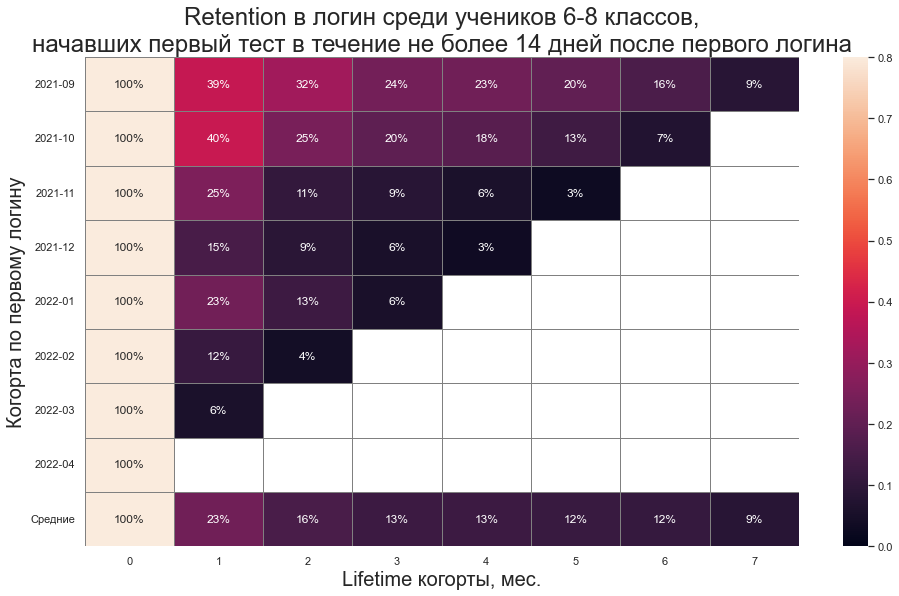

In [54]:
retention_pivot_first_test_in_14_days = retention_first_auth(
    df = users_auth_14_days_test_start,
    heat_title = 'Retention в логин среди учеников 6-8 классов,\nначавших первый тест в течение не более 14 дней после первого логина',
    file_name='retention_grades_6_8_first_test_begin_14_days',
    yticks_rotation=0
)

## <a id='toc9_3_'></a>[Пользователи, которые закончили тест в течение 14 дней после первого логина](#toc0_)

In [55]:
first_test_end_dates = gen_test.query('end > 0').groupby('user_id')['end'].min()

first_test_end_dates = pd.to_datetime(first_test_end_dates, unit='ms')
first_test_end_dates.name = 'test_end'

users = users.join(first_test_end_dates, on='id', how='left')

strange_test_end_len = len(users.query('test_end < test_start'))
print(f'Кол-во пользователей, для которых конец первого теста раньше начала: {strange_test_start_len}')

users['first_test_end_after_first_login_D'] = (
    (users['test_end'] - users['ts_login_first']) / np.timedelta64(1, 'D')
)

users_14_days_test_end = users.query('first_test_end_after_first_login_D < 14')['id'].unique().tolist()

share_14_end = len(users_14_days_test_end) / users['id'].nunique()
print(f'Процент пользователей, закончивших тест в течение 14 дн.: {share_14_end:.1%}')


users_auth_14_days_test_end = users_auth.query('id_user in @users_14_days_test_end').copy()
users_auth_14_days_test_end

Кол-во пользователей, для которых конец первого теста раньше начала: 0
Процент пользователей, закончивших тест в течение 14 дн.: 6.1%


,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
3467,10801,8,49199,2022-02-01,2022-01-31,2022-02-06,712872.0,2022-02-01,2022-01-31,2022-02-06,0
3960,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,691912.0,2022-01-01,2022-01-24,2022-01-24,0
3961,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,692237.0,2022-01-01,2022-01-24,2022-01-25,0
3962,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,693551.0,2022-01-01,2022-01-24,2022-01-26,0
3963,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,695217.0,2022-01-01,2022-01-24,2022-01-27,0
...,...,...,...,...,...,...,...,...,...,...,...
780716,227025,6,230106,2022-04-01,2022-04-18,2022-04-24,NaN,2022-04-01,2022-04-18,2022-04-24,0
780718,227028,8,230109,2022-04-01,2022-04-18,2022-04-24,791081.0,2022-04-01,2022-04-25,2022-04-25,0
780761,227084,7,230165,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780766,227090,6,230171,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0


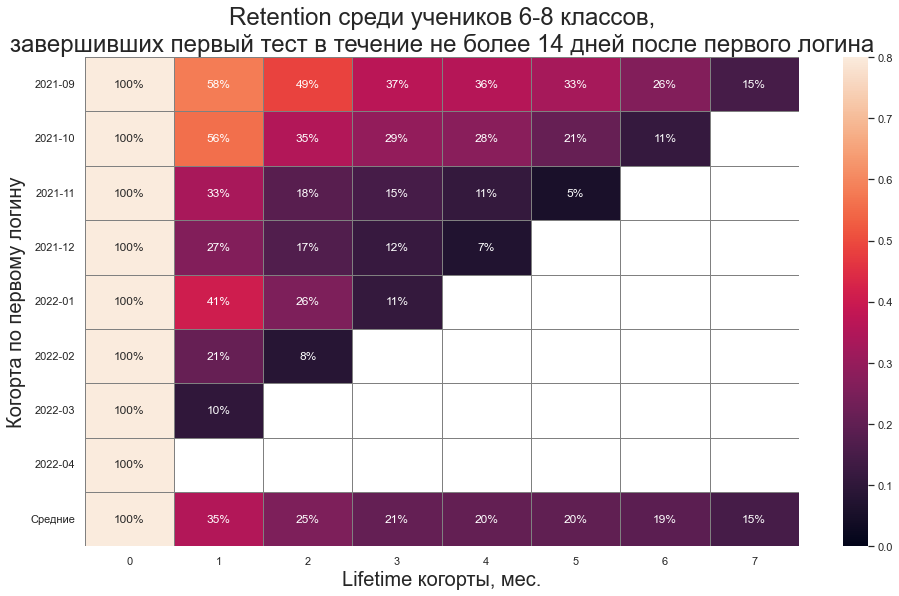

In [56]:
retention_pivot_first_test_end_in_14_days = retention_first_auth(
    df = users_auth_14_days_test_end,
    heat_title = 'Retention среди учеников 6-8 классов,\nзавершивших первый тест в течение не более 14 дней после первого логина',
    file_name='retention_grades_6_8_first_test_end_14_days',
    yticks_rotation=0
)

## <a id='toc9_4_'></a>[Пользователи, которые подали заявку на курс в течение 14 дней после первого логина](#toc0_)

In [57]:
first_app_dates = app_good.groupby('user_id')['ti'].min()
first_app_dates.name = 'first_app_date'

users = users.join(first_app_dates, on='id', how='left')
users['first_app_after_first_login_D'] = (
    (users['first_app_date'] - users['ts_login_first']) / np.timedelta64(1, 'D')
)
users['first_app_after_first_login_D'].describe()

count    4363.000000
mean      220.878454
std       254.171255
min         0.000220
25%         0.043866
50%        96.810637
75%       374.494201
max       963.824398
Name: first_app_after_first_login_D, dtype: float64

In [58]:
users_14_days_app = users.query('first_app_after_first_login_D < 14')['id'].unique().tolist()
users_auth_14_days_app = users_auth.query('id_user in @users_14_days_app').copy()
users_auth_14_days_app

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
3960,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,691912.0,2022-01-01,2022-01-24,2022-01-24,0
3961,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,692237.0,2022-01-01,2022-01-24,2022-01-25,0
3962,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,693551.0,2022-01-01,2022-01-24,2022-01-26,0
3963,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,695217.0,2022-01-01,2022-01-24,2022-01-27,0
3964,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,695272.0,2022-01-01,2022-01-24,2022-01-27,0
...,...,...,...,...,...,...,...,...,...,...,...
780698,227008,6,230089,2022-04-01,2022-04-18,2022-04-24,NaN,2022-04-01,2022-04-18,2022-04-24,0
780704,227014,7,230095,2022-04-01,2022-04-18,2022-04-24,NaN,2022-04-01,2022-04-18,2022-04-24,0
780752,227070,8,230151,2022-04-01,2022-04-25,2022-04-25,790895.0,2022-04-01,2022-04-25,2022-04-25,0
780771,227096,7,230177,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0


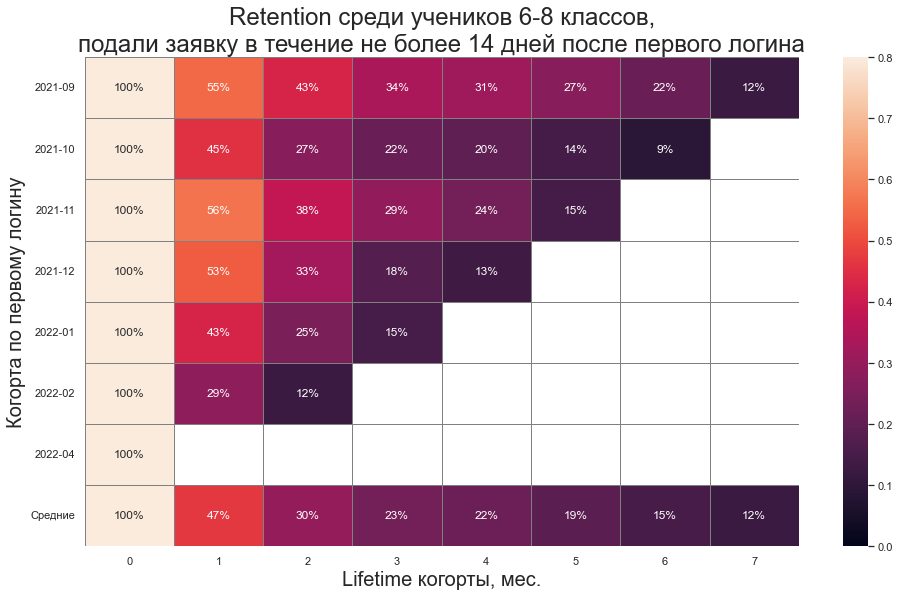

In [59]:
retention_pivot_first_app_in_14_days = retention_first_auth(
    df = users_auth_14_days_app,
    heat_title = 'Retention среди учеников 6-8 классов,\nподали заявку в течение не более 14 дней после первого логина',
    file_name='retention_grades_6_8_first_app_14_days',
    yticks_rotation=0
)

### <a id='toc9_4_1_'></a>[bad_app](#toc0_)

In [60]:
first_app_bad_dates = app_bad.groupby('user_id')['ti'].min()
first_app_bad_dates.name = 'first_app_bad_date'

users = users.join(first_app_bad_dates, on='id', how='left')
users['first_app_bad_after_first_login_D'] = (
    (users['first_app_bad_date'] - users['ts_login_first']) / np.timedelta64(1, 'D')
)

users_14_days_app_bad = users.query('first_app_bad_after_first_login_D < 14')['id'].unique().tolist()
users_auth_14_days_app_bad = users_auth.query('id_user in @users_14_days_app_bad').copy()
users_auth_14_days_app_bad

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
7054,12768,6,67494,2021-11-01,2021-11-08,2021-11-08,569364.0,2021-11-01,2021-11-08,2021-11-08,0
7055,12768,6,67494,2021-11-01,2021-11-08,2021-11-08,610369.0,2021-11-01,2021-11-22,2021-11-28,0
8005,13274,8,57433,2021-10-01,2021-10-25,2021-10-27,548925.0,2021-10-01,2021-10-25,2021-10-27,0
8156,13522,8,51777,2021-11-01,2021-11-08,2021-11-09,571126.0,2021-11-01,2021-11-08,2021-11-09,0
8157,13522,8,51777,2021-11-01,2021-11-08,2021-11-09,587214.0,2021-11-01,2021-11-15,2021-11-17,0
...,...,...,...,...,...,...,...,...,...,...,...
776567,222988,8,225825,2022-02-01,2022-02-21,2022-02-27,775977.0,2022-03-01,2022-03-21,2022-03-24,1
776568,222988,8,225825,2022-02-01,2022-02-21,2022-02-27,779300.0,2022-03-01,2022-03-28,2022-03-31,1
776569,222988,8,225825,2022-02-01,2022-02-21,2022-02-27,789075.0,2022-04-01,2022-04-18,2022-04-19,2
776570,222988,8,225825,2022-02-01,2022-02-21,2022-02-27,790671.0,2022-04-01,2022-04-18,2022-04-24,2


## <a id='toc9_5_'></a>[Пользователи, которые получили одобренную заявку на курс в течение 45 дней после подачи заявки](#toc0_)

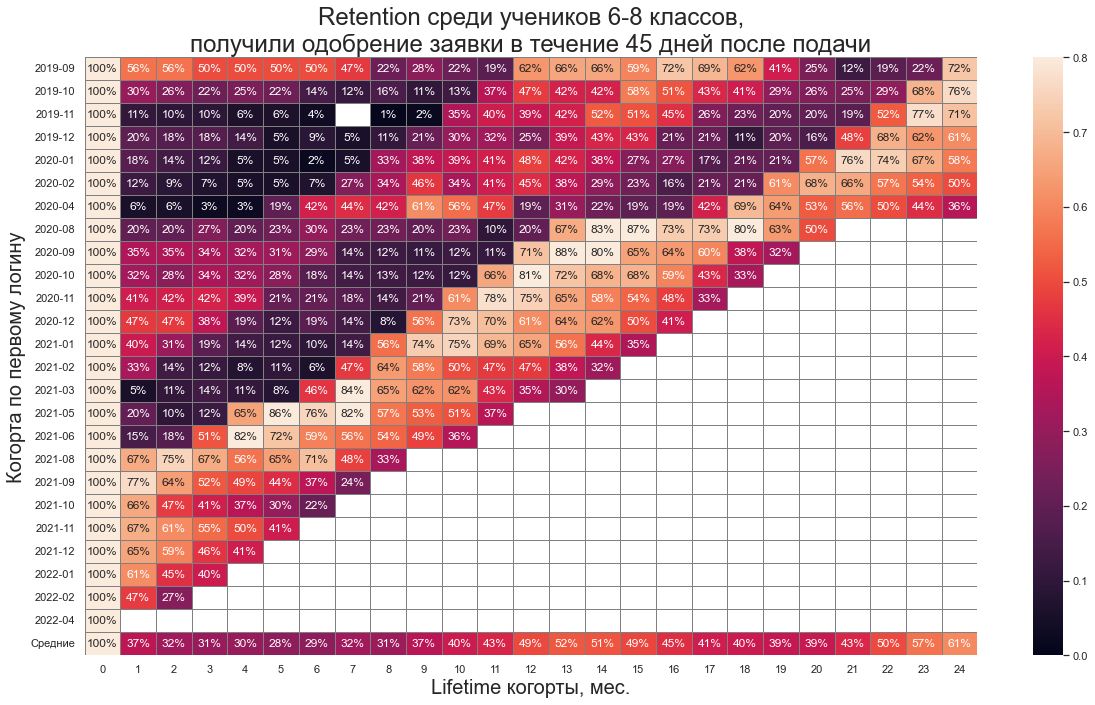

In [61]:
mask = (app_good['state'] == "approved") & (
    (app_good['reviewed_at'] - app_good['ti']) / np.timedelta64(1,'D') < 45)

users_approved_45_days = app_good[mask]['user_id'].unique().tolist()
users_auth_approved_45_days = users_auth.query('id_user in @users_approved_45_days')
retention_pivot_approved_45_days = retention_first_auth(
    df = users_auth_approved_45_days,
    heat_title = 'Retention среди учеников 6-8 классов,\nполучили одобрение заявки в течение 45 дней после подачи',
    file_name='retention_grades_6_8_appoved_45_days',
    yticks_rotation=0,
    figsize=(20,11)
)

In [62]:
'''
retention_monthly(
    retention_pivot = retention_pivot_approved_45_days,
    title='Средний retention в логин по месяцам, 6-8 класс, 2019-2022 годы\nПолучили одобрение заявки в течение 45 дней после подачи',
    figsize=(16,9),
    file_name='retention_monthly_grades_6_8_2019_2022_approved_45_days'
    );'''

"\nretention_monthly(\n    retention_pivot = retention_pivot_approved_45_days,\n    title='Средний retention в логин по месяцам, 6-8 класс, 2019-2022 годы\nПолучили одобрение заявки в течение 45 дней после подачи',\n    figsize=(16,9),\n    file_name='retention_monthly_grades_6_8_2019_2022_approved_45_days'\n    );"

## <a id='toc9_6_'></a>[Пользователи, которые получили отказ](#toc0_)

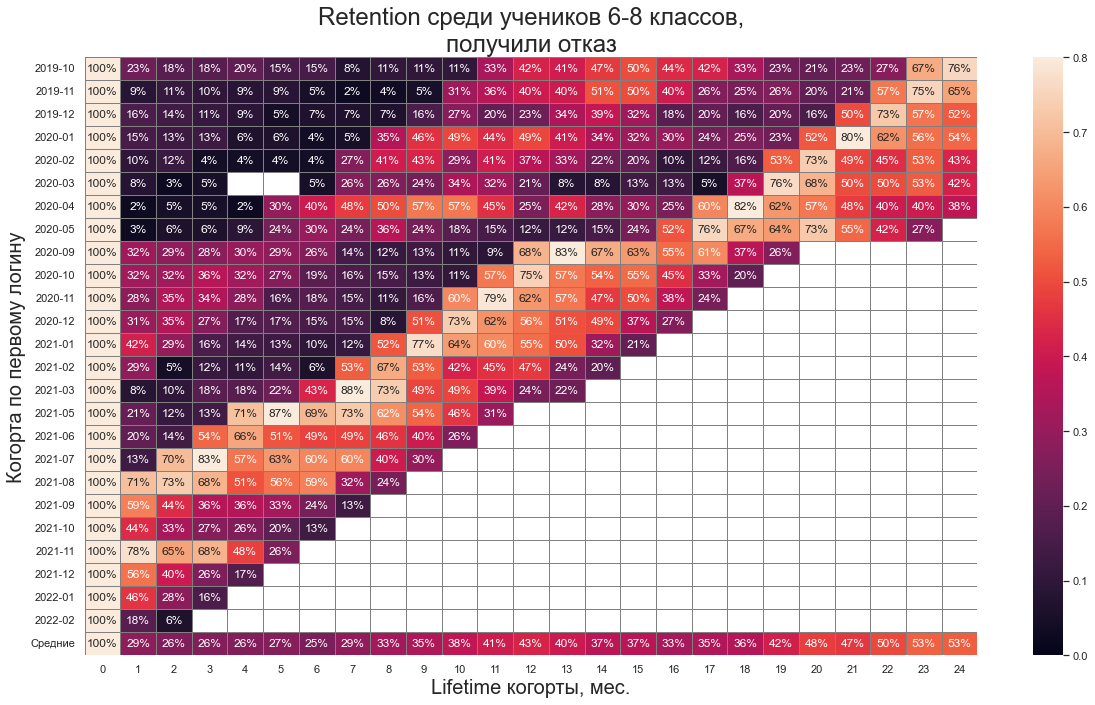

In [63]:
mask = (app_good['state'] == "rejected")

users_rejected = app_good[mask]['user_id'].unique().tolist()
users_auth_rejected = users_auth.query('id_user in @users_rejected')
retention_pivot_rejected = retention_first_auth(
    df = users_auth_rejected,
    heat_title = 'Retention среди учеников 6-8 классов,\nполучили отказ',
    file_name='retention_grades_6_8_rejected',
    yticks_rotation=0,
    figsize=(20,11)
)

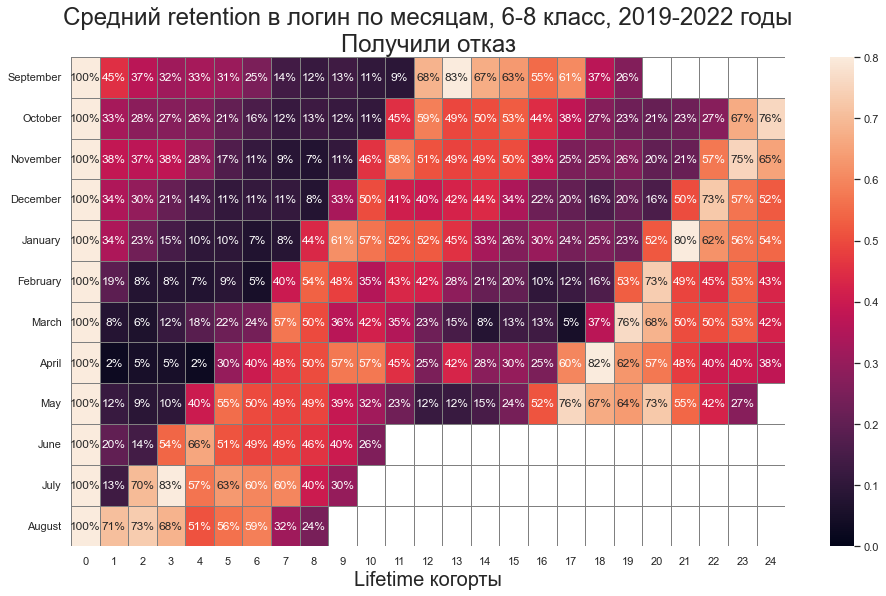

In [64]:
retention_monthly(
    retention_pivot = retention_pivot_rejected,
    title='Средний retention в логин по месяцам, 6-8 класс, 2019-2022 годы\nПолучили отказ',
    figsize=(16,9),
    file_name='retention_monthly_grades_6_8_2019_2022_rejected'
    );

## <a id='toc9_7_'></a>[Пользователи, которые подали заявку на обучение в школе](#toc0_)

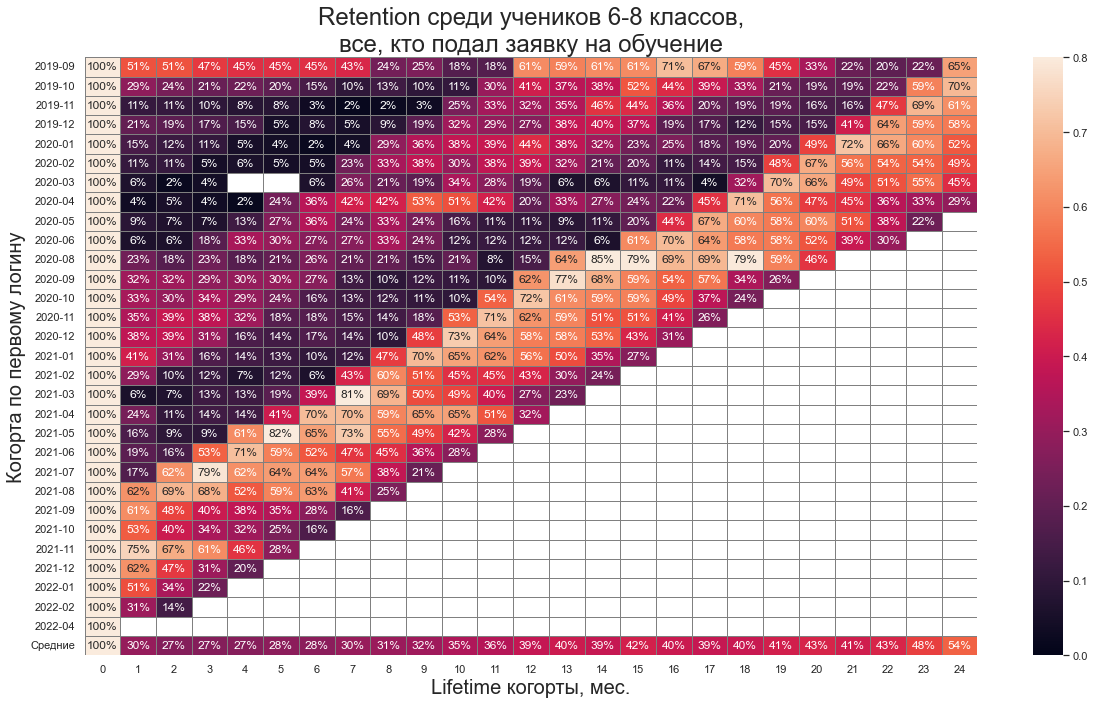

In [65]:
users_applied = app_good['user_id'].unique().tolist()
users_auth_applied = users_auth.query('id_user in @users_applied')
retention_pivot_applied = retention_first_auth(
    df = users_auth_applied,
    heat_title = 'Retention среди учеников 6-8 классов,\nвсе, кто подал заявку на обучение',
    file_name='retention_grades_6_8_applied',
    yticks_rotation=0,
    figsize=(20,11)
)

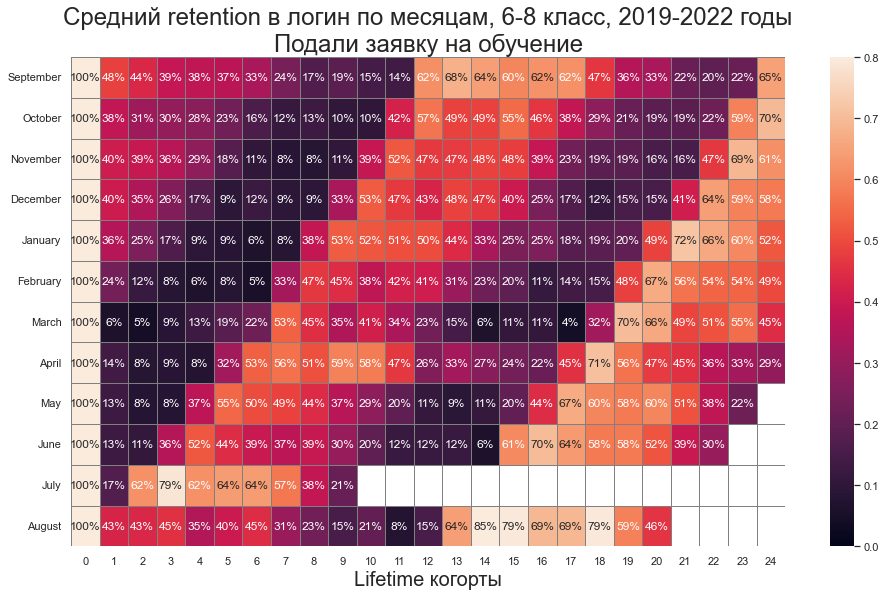

In [66]:
retention_monthly(
    retention_pivot = retention_pivot_applied,
    title='Средний retention в логин по месяцам, 6-8 класс, 2019-2022 годы\nПодали заявку на обучение',
    figsize=(16,9),
    file_name='retention_monthly_grades_6_8_2019_2022_apllied'
    );

## <a id='toc9_8_'></a>[Вывод по подсчету retention](#toc0_)

- Retention имеет тенденцию к росту при переходе по цепочке: логин -> нач. тест -> закон. тест. Заявка на курс в плане retention лучше, чем начавшие тест, но хуже, чем те, кто тест завершил.

- есть тенденция на снижение с 2019 до 2021 года

- сезонные пики: май, июнь, июль ,август, сентябрь, октябрь, ноябрь, декабрь, январь - высокий сезон, особенно выраженный в сентябре-октябре, что логично.


# <a id='toc10_'></a>[Когортный анализ основных показателей](#toc0_)

1. **Когортный анализ по неделям для новых пользователей в 2021-2022 гг.** 
    1. Число новых пользователей в когорте 
    2. Начали проходить тест в течение 14 дней после регистрации
    3. Закончили проходить тест в течение 30 дней после регистрации
    4. Подали заявку на курс в течение 14 дней после регистрации
       - заявки чисто на курс
       - заявки на олимпиады
    5. Решили одно олимпиадное задание в течение 14 дней 
    6. Подали заявку в школу 
    7. Retention новых пользователей в авторизацию на 1, 7 и 30 день

Мы уже ранее сделали подготовку к вычислению почти всех показателей, кроме E и F. Дополним наши данные

## <a id='toc10_1_'></a>[Участие в олимпиадах](#toc0_)

In [68]:
first_olymp = olymp[olymp['Статус'] == 'Завершено'].groupby('GID абитуриента')['Дата выполнения'].min()
first_olymp.name = 'olymp_date'
users = users.join(first_olymp, on='id___global', how='left')
users_14_day_olymp = users[users['olymp_date'] - users['first_login_D'] < np.timedelta64(14, 'D')
                          ]['id'].unique().tolist()
users_auth_14_day_olymp = users_auth.query('id_user in @users_14_day_olymp')
users_auth_14_day_olymp

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
3960,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,691912.0,2022-01-01,2022-01-24,2022-01-24,0
3961,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,692237.0,2022-01-01,2022-01-24,2022-01-25,0
3962,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,693551.0,2022-01-01,2022-01-24,2022-01-26,0
3963,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,695217.0,2022-01-01,2022-01-24,2022-01-27,0
3964,11289,6,34812,2022-01-01,2022-01-24,2022-01-24,695272.0,2022-01-01,2022-01-24,2022-01-27,0
...,...,...,...,...,...,...,...,...,...,...,...
780731,227046,8,230127,2022-04-01,2022-04-18,2022-04-24,NaN,2022-04-01,2022-04-18,2022-04-24,0
780755,227076,7,230157,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780795,227130,6,230211,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0
780798,227133,6,230214,2022-04-01,2022-04-25,2022-04-25,NaN,2022-04-01,2022-04-25,2022-04-25,0


## <a id='toc10_2_'></a>[Заявка в школу](#toc0_)

In [69]:
users_school_app_ls = school_app['crm_lead_id'].unique().tolist()

users_auth_school_app = users_auth.query('id___global in @users_school_app_ls')
users_auth_school_app

,id_user,grade_id,id___global,first_login_M,first_login_W,first_login_D,id_auth,M,W,D,cohort_lifetime
397,9882,7,713,2019-12-01,2019-12-09,2019-12-13,668195.0,2022-01-01,2022-01-03,2022-01-07,25
398,9882,7,713,2019-12-01,2019-12-09,2019-12-13,672827.0,2022-01-01,2022-01-10,2022-01-11,25
399,9882,7,713,2019-12-01,2019-12-09,2019-12-13,679949.0,2022-01-01,2022-01-17,2022-01-17,25
400,9882,7,713,2019-12-01,2019-12-09,2019-12-13,679960.0,2022-01-01,2022-01-17,2022-01-17,25
401,9882,7,713,2019-12-01,2019-12-09,2019-12-13,681031.0,2022-01-01,2022-01-17,2022-01-18,25
...,...,...,...,...,...,...,...,...,...,...,...
779968,226221,8,229299,2022-04-01,2022-04-11,2022-04-13,788961.0,2022-04-01,2022-04-18,2022-04-19,0
779969,226221,8,229299,2022-04-01,2022-04-11,2022-04-13,789669.0,2022-04-01,2022-04-18,2022-04-21,0
779970,226221,8,229299,2022-04-01,2022-04-11,2022-04-13,790050.0,2022-04-01,2022-04-18,2022-04-22,0
780767,227092,6,230173,2022-04-01,2022-04-25,2022-04-25,791011.0,2022-04-01,2022-04-25,2022-04-25,0


In [70]:
users['id__reg_place'].value_counts()

2    70001
1    26029
Name: id__reg_place, dtype: int64

In [71]:
users_LO = users.query('id__reg_place == 2')['id'].unique().tolist()
users_LR = users.query('id__reg_place == 1')['id'].unique().tolist()

## <a id='toc10_3_'></a>[Когортный анализ](#toc0_)

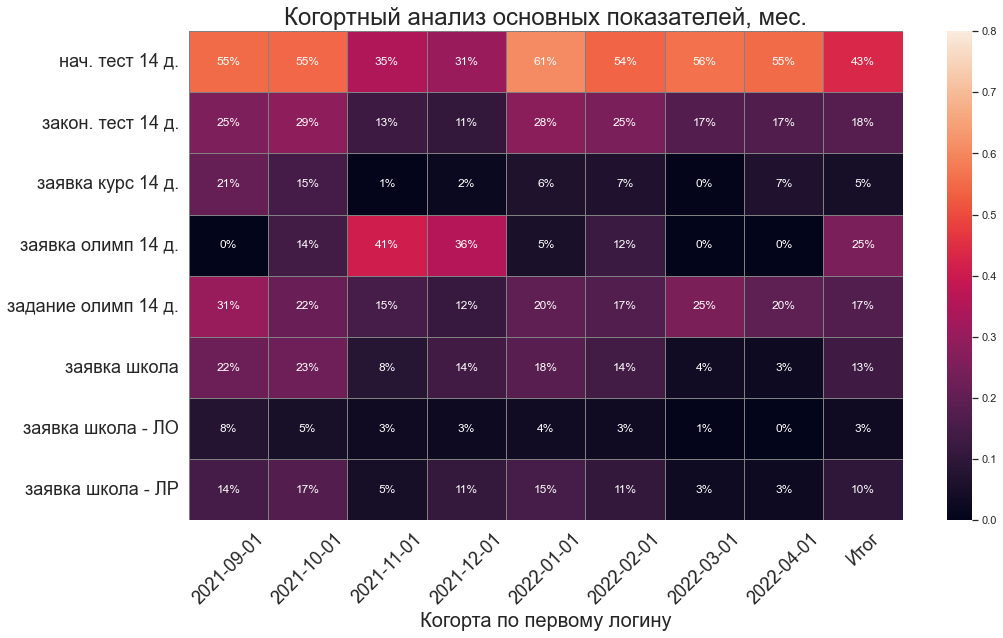

новые пользователи        нач. тест 14 д.       закон. тест 14 д.  \
                       кол-во      %          кол-во     %            кол-во   
2021-09-01             1758.0  100.0           972.0  55.0             448.0   
2021-10-01             2870.0  100.0          1567.0  55.0             818.0   
2021-11-01            10087.0  100.0          3500.0  35.0            1309.0   
2021-12-01             7928.0  100.0          2430.0  31.0             863.0   
2022-01-01             3341.0  100.0          2033.0  61.0             921.0   
2022-02-01             4387.0  100.0          2367.0  54.0            1092.0   
2022-03-01             1241.0  100.0           698.0  56.0             216.0   
2022-04-01              932.0  100.0           515.0  55.0             157.0   
Итог                  32544.0  100.0         14082.0  43.0            5824.0   

                 заявка курс 14 д.       заявка олимп 14 д.        \
               %            кол-во     %             кол-во     %   
2021-09-01  25.0             371.0  21.0                0.0   0.0   
2021-10-01  29.0             421.0  15.0              409.0  14.0   
2021-11-01  13.0              55.0   1.0             4137.0  41.0   
2021-12-01  11.0             165.0   2.0             2844.0  36.0   
2022-01-01  28.0             214.0   6.0              181.0   5.0   
2022-02-01  25.0             294.0   7.0              536.0  12.0   
2022-03-01  17.0               4.0   0.0                0.0   0.0   
2022-04-01  17.0              64.0   7.0                0.0   0.0   
Итог        18.0            1588.0   5.0             8107.0  25.0   

           задание олимп 14 д.       заявка школа       заявка школа - ЛО  \
                        кол-во     %       кол-во     %            кол-во   
2021-09-01               538.0  31.0        389.0  22.0             136.0   
2021-10-01               621.0  22.0        649.0  23.0             151.0   
2021-11-01              1501.0  15.0        835.0   8.0             336.0   
2021-12-01               940.0  12.0       1103.0  14.0             221.0   
2022-01-01               660.0  20.0        612.0  18.0             117.0   
2022-02-01               751.0  17.0        620.0  14.0             142.0   
2022-03-01               311.0  25.0         44.0   4.0               7.0   
2022-04-01               182.0  20.0         25.0   3.0               0.0   
Итог                    5504.0  17.0       4277.0  13.0            1110.0   

                заявка школа - ЛР        
              %            кол-во     %  
2021-09-01  8.0             253.0  14.0  
2021-10-01  5.0             498.0  17.0  
2021-11-01  3.0             499.0   5.0  
2021-12-01  3.0             882.0  11.0  
2022-01-01  4.0             495.0  15.0  
2022-02-01  3.0             478.0  11.0  
2022-03-01  1.0              37.0   3.0  
2022-04-01  0.0              25.0   3.0  
Итог        3.0            3167.0  10.0

In [72]:
def cohorts_count(df=users_auth,
             query = 'first_login_M >= "2021-09-01"', 
             period:str='M', 
             name:str='новые пользователи') -> pd.Series:
    '''
    Calculates number of unique users in each cohort. Cohorts can be monthly, weekly or daily.
    
    Input:
        df - data
        query - extra query on data
        period - 'M', 'W' or 'D'
        name - name of the resultant pd.Series
        
    Returns: pd.Series with count of users in each cohort
    '''
    
    if period not in ['M', 'W', 'D']:
        raise ValueError
        print('Illegal period value. Try: "M", "W" or "D".')
    
    users_count = df.query(query).groupby('first_login_' + period)['id_user'].nunique()
    users_count.name = name
    
    return users_count

def cohorts_main_metrics(period:str='M', 
                         viz:bool=True,
                         figsize:tuple=(16,9), 
                         file_name:str='cohorts_main_metrics',
                         orient:str='h',
                         retention:bool=False
                         ) -> pd.DataFrame:
    '''
    Calculates main cohort metrics which are interesting for Letovo.Online. 
    Returns a dataframe with count of users in each cohort and column and percentage of initial count.
    
    Input:
        period - cohort period, can be 'M', 'W' or 'D'
        viz - whether to plot the heatmap of percentages
        figsize - size of heatmap figure
        file_name - name of file to use when saving the result
        orient - orientation of the heatmap, can be 'h' or 'v'
        
    Return: pd.DataFrame 
    '''
    
    
    if period not in ['M', 'W', 'D']:
        raise ValueError
        print('Illegal period value. Try: "M", "W" or "D".')
    
    # Find main metrics
    result_ls = []
    result_ls.append(cohorts_count(period=period))
    result_ls.append(cohorts_count(df=users_auth_14_days_test_start, name='нач. тест 14 д.', period=period))
    result_ls.append(cohorts_count(df=users_auth_14_days_test_end, name='закон. тест 14 д.', period=period))
    result_ls.append(cohorts_count(df=users_auth_14_days_app, name='заявка курс 14 д.', period=period))
    result_ls.append(cohorts_count(df=users_auth_14_days_app_bad, name='заявка олимп 14 д.', period=period))
    result_ls.append(cohorts_count(df=users_auth_14_day_olymp, name='задание олимп 14 д.', period=period))
    result_ls.append(cohorts_count(df=users_auth_school_app, name='заявка школа', period=period))
    result_ls.append(cohorts_count(df=users_auth_school_app.query('id_user in @users_LO'), 
                                   name='заявка школа - ЛО', period=period))
    result_ls.append(cohorts_count(df=users_auth_school_app.query('id_user in @users_LR'), 
                                   name='заявка школа - ЛР', period=period))
    
    #retention
    if retention:
        
        result_ls.append(cohorts_count(df=users_auth[users_auth['D'] - users_auth['first_login_D'] <= np.timedelta64(1, 'D')], 
                                       name='retention 1 д.', period=period))
        result_ls.append(cohorts_count(df=users_auth[users_auth['D'] - users_auth['first_login_D'] <= np.timedelta64(7, 'D')], 
                                       name='retention 7 д.', period=period))
        result_ls.append(cohorts_count(df=users_auth[users_auth['D'] - users_auth['first_login_D'] <= np.timedelta64(30, 'D')], 
                                       name='retention 30 д.', period=period))
    
    
    result = pd.concat(result_ls, axis=1).fillna(0)
    result.index = pd.Series(result.index).dt.date.values
    
    
    #save initial column order and index
    column_names = result.columns
    cohorts = result.index
    
    result.loc['Итог'] = result.sum()
    result_ratio = result.div(result.iloc[:, 0], axis=0)
    #result_ratio.loc['средние'] = result_ratio.mean()
    
    #plot the heatmap
    sns.set(style='white', font_scale=1)
    fig = plt.figure(figsize=figsize)
    
    period_dict = {'M':'мес.', 'W':'нед.', 'D':'день'}
    
    plt.title('Когортный анализ основных показателей, ' + period_dict[period], size=24)  
    
    if orient not in ['h', 'v']:
        raise ValueError
        print('Illegal orient value. Try: "h" or "v".')
    
    if orient == 'h':
        res = result_ratio.iloc[:, 1:].T
        ax = sns.heatmap(res,
            annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='gray', 
            vmin=0, vmax=0.8
            #xticklabels=x_ticks
        )
        
        plt.xlabel('Когорта по первому логину', size=20)
        plt.yticks(rotation=0, size=18)
        plt.xticks(rotation=45, size=18)
        
    if orient == 'v':
        res = result_ratio.iloc[:, 1:]
        ax = sns.heatmap(res,
            annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='gray', 
            vmin=0, vmax=0.8
            #yticklabels=y_ticks
        )
        
        plt.ylabel('Когорта по первому логину', size=20)
        plt.xticks(rotation=20, size=18)
        plt.yticks(size=18)
    
    
    plt.show()
    
    
    
    # round and append means
    result_ratio = (result_ratio * 100).round(0)
    
    #build multiindex
    result.columns = pd.MultiIndex.from_product([column_names, ['кол-во']])
    result_ratio.columns = pd.MultiIndex.from_product([column_names, ['%']])

    #join and recover column order
    final = pd.concat([result, result_ratio], axis=1)
    idx = pd.IndexSlice
    final = final.loc[:, idx[column_names,:]]
    
    
    #save
    fig.savefig(file_name + '_' + period + '.png', bbox_inches='tight')
    final.to_csv(file_name + '_' + period + '.csv')
   
    
    return final

cohorts_main_metrics()

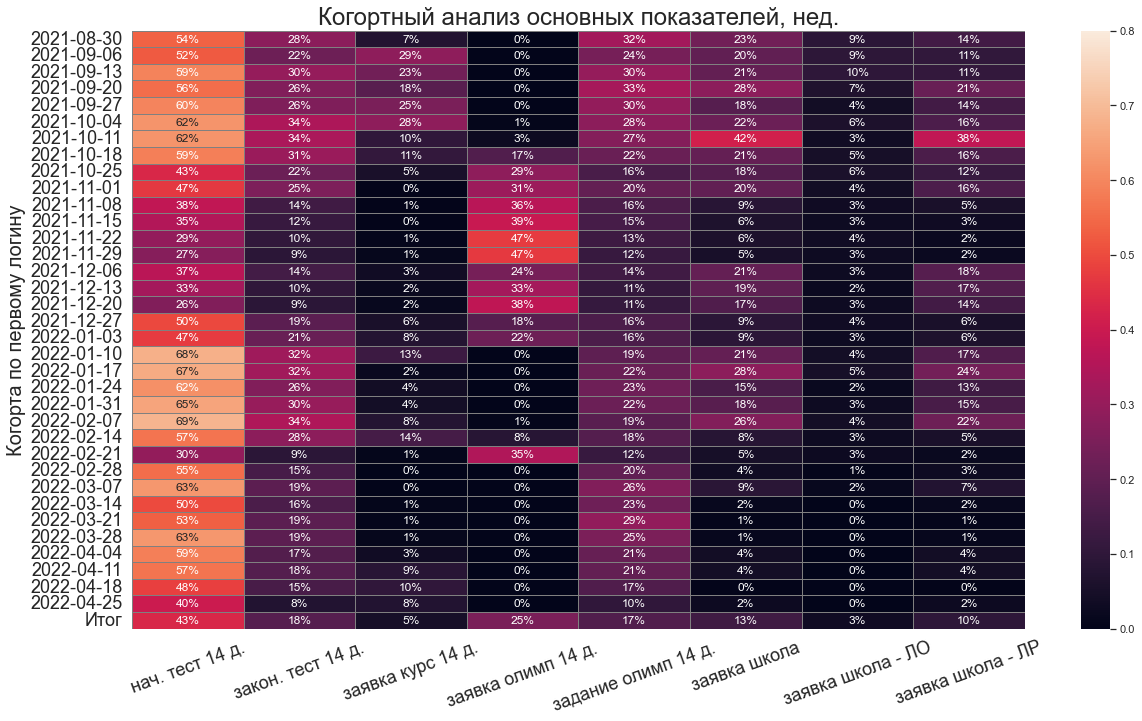

новые пользователи        нач. тест 14 д.       закон. тест 14 д.  \
                       кол-во      %          кол-во     %            кол-во   
2021-08-30              151.0  100.0            81.0  54.0              42.0   
2021-09-06              445.0  100.0           233.0  52.0             100.0   
2021-09-13              326.0  100.0           193.0  59.0              97.0   
2021-09-20              535.0  100.0           297.0  56.0             139.0   
2021-09-27              549.0  100.0           327.0  60.0             142.0   
2021-10-04              702.0  100.0           438.0  62.0             241.0   
2021-10-11              373.0  100.0           232.0  62.0             126.0   
2021-10-18              440.0  100.0           258.0  59.0             135.0   
2021-10-25             1107.0  100.0           480.0  43.0             244.0   
2021-11-01             1268.0  100.0           592.0  47.0             321.0   
2021-11-08             2061.0  100.0           781.0  38.0             280.0   
2021-11-15             2813.0  100.0           985.0  35.0             328.0   
2021-11-22             2945.0  100.0           868.0  29.0             305.0   
2021-11-29             3665.0  100.0           987.0  27.0             338.0   
2021-12-06             1586.0  100.0           580.0  37.0             224.0   
2021-12-13             1706.0  100.0           555.0  33.0             172.0   
2021-12-20             1623.0  100.0           421.0  26.0             149.0   
2021-12-27              432.0  100.0           214.0  50.0              81.0   
2022-01-03              752.0  100.0           357.0  47.0             160.0   
2022-01-10              735.0  100.0           497.0  68.0             232.0   
2022-01-17              808.0  100.0           540.0  67.0             258.0   
2022-01-24              837.0  100.0           516.0  62.0             219.0   
2022-01-31              903.0  100.0           591.0  65.0             272.0   
2022-02-07             1233.0  100.0           845.0  69.0             424.0   
2022-02-14             1057.0  100.0           600.0  57.0             300.0   
2022-02-21             1261.0  100.0           374.0  30.0             115.0   
2022-02-28              300.0  100.0           166.0  55.0              45.0   
2022-03-07              276.0  100.0           174.0  63.0              53.0   
2022-03-14              293.0  100.0           146.0  50.0              46.0   
2022-03-21              271.0  100.0           144.0  53.0              51.0   
2022-03-28              276.0  100.0           174.0  63.0              53.0   
2022-04-04              259.0  100.0           152.0  59.0              45.0   
2022-04-11              233.0  100.0           132.0  57.0              41.0   
2022-04-18              283.0  100.0           136.0  48.0              43.0   
2022-04-25               40.0  100.0            16.0  40.0               3.0   
Итог                  32544.0  100.0         14082.0  43.0            5824.0   

                 заявка курс 14 д.       заявка олимп 14 д.        \
               %            кол-во     %             кол-во     %   
2021-08-30  28.0              11.0   7.0                0.0   0.0   
2021-09-06  22.0             127.0  29.0                0.0   0.0   
2021-09-13  30.0              76.0  23.0                0.0   0.0   
2021-09-20  26.0              97.0  18.0                0.0   0.0   
2021-09-27  26.0             136.0  25.0                0.0   0.0   
2021-10-04  34.0             200.0  28.0                6.0   1.0   
2021-10-11  34.0              38.0  10.0               10.0   3.0   
2021-10-18  31.0              48.0  11.0               75.0  17.0   
2021-10-25  22.0              59.0   5.0              318.0  29.0   
2021-11-01  25.0               6.0   0.0              396.0  31.0   
2021-11-08  14.0              11.0   1.0              748.0  36.0   
2021-11-15  12.0              11.0   0.0             1109.0  39.0   
2021

In [73]:
cohorts_main_metrics(period='W', orient='v', figsize=(20, 11))

## <a id='toc10_4_'></a>[Вывод по когортному анализу](#toc0_)

- Конверсия в заявку на курс совсем низкая, ниже, чем на олимпиады
- В ноябре и декабре всплеск заявок на олимпиады
- Высокий процент заявок на курс видим только в сентябре и начале октября
- Самая высокая конверсия в заявку на обучение в школе на вторую неделю октября (33%)

# <a id='toc11_'></a>[Конверсия в заявку в школу из разных источников 2021-2022](#toc0_)

In [74]:
# Начали тест в теч. 14 дн.
test_begin = users.query('first_test_start_after_first_login_D < 14 and first_login_M >= "2021-09-01"'
                            )['id'].unique().tolist()
# Заявка на курс в теч. 14 дн.       
course_app = users.query('first_app_after_first_login_D < 14 and first_login_M >= "2021-09-01"'
                           )['id'].unique().tolist()
# Заявка на олимп в теч. 14 дн.
olymp_app = users.query('first_app_bad_after_first_login_D < 14 and first_login_M >= "2021-09-01"'
                           )['id'].unique().tolist()

# Пробовали решать олимпиаду в теч. 14 дн.
olymp_solv = users.query('first_login_M >= "2021-09-01"')[users['olymp_date'] - users['first_login_D'] < np.timedelta64(14, 'D')
                                                         ]['id'].unique().tolist()
# Подали заявку в школу
school_app_ls = users.query('first_login_M >= "2021-09-01" and id___global in @users_school_app_ls')['id'].unique().tolist()

data_dict = {'test_begin':test_begin,
             'course_app':course_app,
             'olymp_app':olymp_app,
             'olymp_solv':olymp_solv,
             'school_app':school_app_ls

}

'''
import json
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=4)'''


"\nimport json\nwith open('data.json', 'w', encoding='utf-8') as f:\n    json.dump(data_dict, f, ensure_ascii=False, indent=4)"

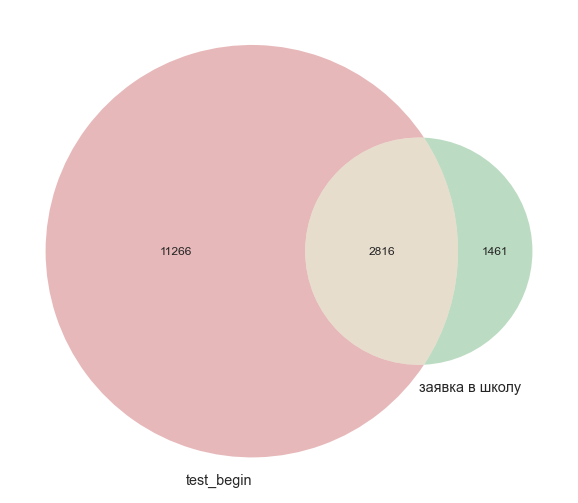

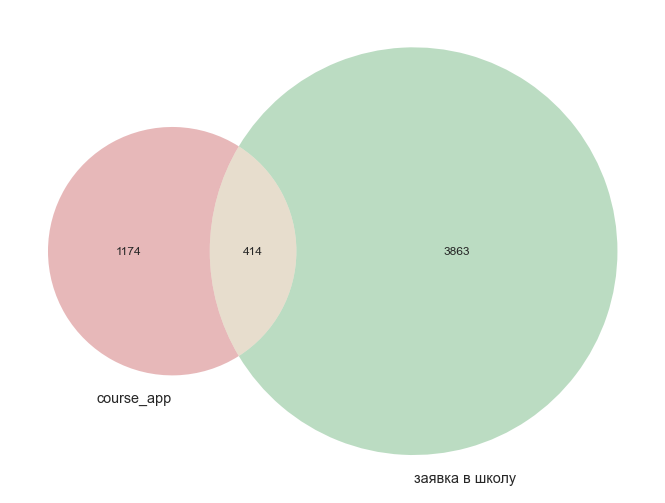

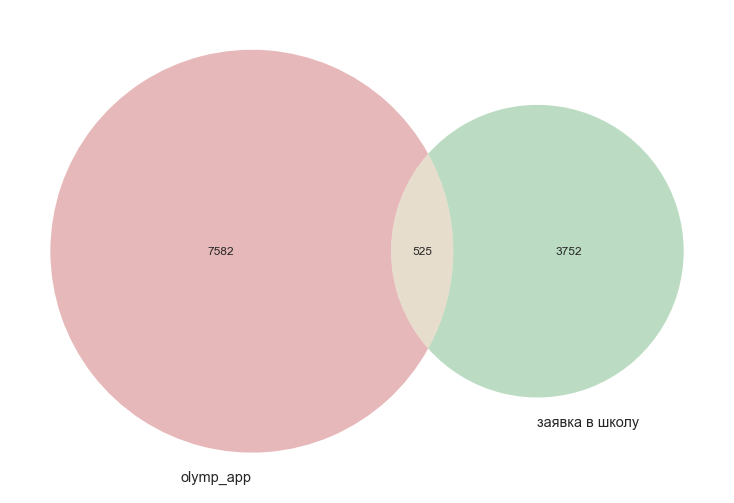

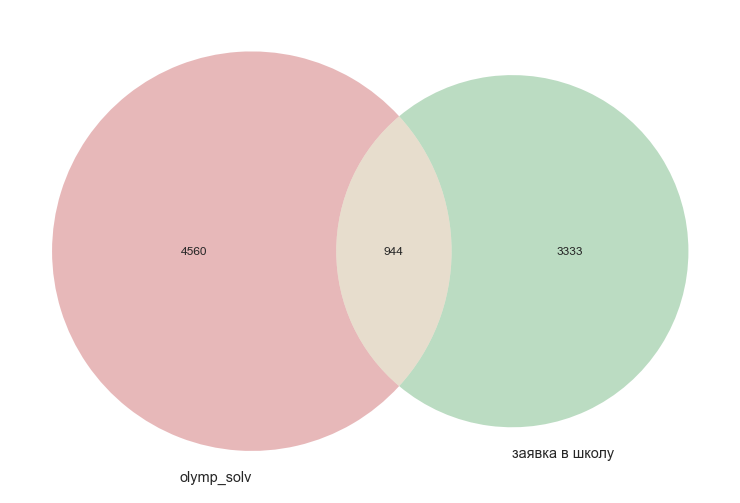

{'test_begin': 0.19997159494390002,
 'course_app': 0.2607052896725441,
 'olymp_app': 0.06475885037621808,
 'olymp_solv': 0.17151162790697674}

In [75]:
conv_dict = {}
for i, key in enumerate(data_dict.keys()):
    if i < 4:
        set_feature = set(data_dict[key])
        set_target = set(school_app_ls)
        conv_dict[key] = len(set_feature & set_target) / len(set_feature)
        
        #total = len(set_feature | set_target)
        venn2([set(data_dict[key]), set(school_app_ls)], [key, 'заявка в школу'])
             #subset_label_formatter= lambda x: f"{(x/total):1.1%}")
        plt.show()
        
conv_dict        

Видим, что у нас самая высокая конверсия в заявку на обучение из начавших тест и подавших заявки (16%). Из олимпиад всего 6,4% из тех, кто подал заявку и 10% из тех, кто начал решать.

In [76]:
pd.Series(conv_dict).to_csv('conv_school.csv')

In [77]:
ls=[]
for key in data_dict.keys():
    ls.append(pd.Series(data_dict[key], name=key))
pd.concat(ls, axis=1).to_csv('unique_users_2021_2022.csv')